In [8]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical,kl_divergence
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [9]:
import gc
gc.collect()

3560

In [10]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Apr 13 23:27:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  8%   52C    P2              57W / 250W |   1220MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [16]:
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
env_id="MountainCar-v0"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_vec_env_sb3(env_id, n_envs=1)

print(env.action_space.n)
print(env.observation_space.shape[0])

(500000, 2) (500000,) (500000,) (500000,) (500000,) (500000, 2)
[-0.43945786  0.        ] 0 -1.0 False {'TimeLimit.truncated': False} [-0.44108224 -0.00162438]
3
2


In [13]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

# Simple KTO

In [17]:
policy_network = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)

nn.init.kaiming_normal_(policy_network.fc1.weight)
nn.init.kaiming_normal_(policy_network.fc2.weight)
nn.init.kaiming_normal_(policy_network.fc3.weight)
prev = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)
env=make_vec_env_sb3(env_id, n_envs=1)

# Training loop
num_epochs = 5
batch_size = 128

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//100
now_log=0
now_pos=0
prev_load_freq = 1000
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        model_dist = Categorical(logits=logits)
        model_act_sample = model_dist.sample()
        policy_chosen_logps = model_dist.log_prob(act_batch)
        policy_rejected_logps = model_dist.log_prob(model_act_sample)
        with torch.no_grad():
            prev_logits = prev(obs_batch)
            prev_dist = Categorical(logits=prev_logits)
            reference_chosen_logps = prev_dist.log_prob(act_batch)
            reference_rejected_logps = prev_dist.log_prob(model_act_sample)
        
        
        beta = 1


        # simple version KTO
        chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        rejected_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        chosen_logratios = (policy_chosen_logps - reference_chosen_logps)
        rejected_logratios = (policy_rejected_logps - reference_rejected_logps)

        losses = torch.cat((1 - F.sigmoid(beta * (chosen_logratios - rejected_KL)), 1 - F.sigmoid(beta * (chosen_KL - rejected_logratios))), 0)

        chosen_rewards = beta * (policy_chosen_logps - reference_chosen_logps).detach()
        rejected_rewards = beta * (policy_rejected_logps - reference_rejected_logps).detach()
        loss=losses.mean()

 
        # Optimize the policy
        
        optimizer.zero_grad()
        if (step+1) % prev_load_freq == 0:
            prev.load_state_dict(policy_network.state_dict())
            prev.eval()

        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_rewards.mean().item()
        negative_reward = rejected_rewards.mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        total_reward=0
        num_test=10
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"epoch_{epoch+1}_iteration_{now_pos}.gif"
                    imageio.mimsave("./Simple_KTO_gif/"+image_path, frames)
            print(total_reward/num_test)
            eval_rewards.append(total_reward/num_test)
            policy_network.train()  # 切换回训练模式


         

env.close()

Epoch [1/5]:   2%|▏         | 68/3907 [00:05<05:48, 11.00it/s, loss=0.481, positive_reward=0.187, negative_reward=0.104, margin=0.0825]   

[-200.]


Epoch [1/5]:   3%|▎         | 100/3907 [00:11<07:31,  8.43it/s, loss=0.489, positive_reward=0.198, negative_reward=0.15, margin=0.0481]  

[-200.]


Epoch [1/5]:   3%|▎         | 136/3907 [00:16<07:43,  8.13it/s, loss=0.481, positive_reward=0.195, negative_reward=0.113, margin=0.082]  

[-200.]


Epoch [1/5]:   5%|▍         | 185/3907 [00:22<07:17,  8.52it/s, loss=0.484, positive_reward=0.282, negative_reward=0.208, margin=0.0748]

[-200.]


Epoch [1/5]:   6%|▌         | 216/3907 [00:28<08:00,  7.68it/s, loss=0.456, positive_reward=0.411, negative_reward=0.218, margin=0.194] 

[-200.]


Epoch [1/5]:   7%|▋         | 262/3907 [00:33<07:15,  8.38it/s, loss=0.469, positive_reward=0.483, negative_reward=0.346, margin=0.137] 

[-190.4]


Epoch [1/5]:   7%|▋         | 286/3907 [00:38<08:33,  7.06it/s, loss=0.49, positive_reward=0.481, negative_reward=0.439, margin=0.0418] 

[-170.]


Epoch [1/5]:   9%|▊         | 337/3907 [00:44<07:25,  8.01it/s, loss=0.481, positive_reward=0.556, negative_reward=0.48, margin=0.0766] 

[-160.7]


Epoch [1/5]:   9%|▉         | 371/3907 [00:49<06:43,  8.77it/s, loss=0.469, positive_reward=0.639, negative_reward=0.487, margin=0.151]  

[-145.8]


Epoch [1/5]:  11%|█         | 411/3907 [00:52<05:11, 11.21it/s, loss=0.46, positive_reward=0.593, negative_reward=0.402, margin=0.191]   

[-143.3]


Epoch [1/5]:  12%|█▏        | 460/3907 [00:55<04:15, 13.51it/s, loss=0.5, positive_reward=0.57, negative_reward=0.588, margin=-.0173]    

[-148.4]


Epoch [1/5]:  13%|█▎        | 493/3907 [00:59<04:18, 13.21it/s, loss=0.496, positive_reward=0.592, negative_reward=0.586, margin=0.00599]

[-137.9]


Epoch [1/5]:  13%|█▎        | 527/3907 [01:02<04:21, 12.92it/s, loss=0.478, positive_reward=0.645, negative_reward=0.538, margin=0.106]   

[-121.4]


Epoch [1/5]:  14%|█▍        | 563/3907 [01:06<05:05, 10.94it/s, loss=0.472, positive_reward=0.594, negative_reward=0.461, margin=0.133]  

[-151.5]


Epoch [1/5]:  16%|█▌        | 609/3907 [01:11<05:39,  9.73it/s, loss=0.485, positive_reward=0.676, negative_reward=0.619, margin=0.0572] 

[-140.6]


Epoch [1/5]:  16%|█▋        | 642/3907 [01:17<06:23,  8.51it/s, loss=0.509, positive_reward=0.509, negative_reward=0.556, margin=-.0472] 

[-154.8]


Epoch [1/5]:  18%|█▊        | 691/3907 [01:21<04:59, 10.75it/s, loss=0.481, positive_reward=0.691, negative_reward=0.604, margin=0.0867] 

[-133.8]


Epoch [1/5]:  18%|█▊        | 722/3907 [01:24<04:21, 12.17it/s, loss=0.489, positive_reward=0.627, negative_reward=0.544, margin=0.0828] 

[-117.9]


Epoch [1/5]:  20%|█▉        | 775/3907 [01:26<03:09, 16.49it/s, loss=0.476, positive_reward=0.639, negative_reward=0.526, margin=0.113]  

[-121.7]


Epoch [1/5]:  21%|██        | 807/3907 [01:29<03:24, 15.16it/s, loss=0.517, positive_reward=0.505, negative_reward=0.584, margin=-.0792] 

[-118.7]


Epoch [1/5]:  22%|██▏       | 841/3907 [01:33<03:42, 13.78it/s, loss=0.51, positive_reward=0.602, negative_reward=0.654, margin=-.052]   

[-116.6]


Epoch [1/5]:  22%|██▏       | 879/3907 [01:36<03:48, 13.28it/s, loss=0.5, positive_reward=0.562, negative_reward=0.562, margin=-.000459]  

[-119.3]


Epoch [1/5]:  24%|██▎       | 923/3907 [01:40<04:15, 11.69it/s, loss=0.493, positive_reward=0.596, negative_reward=0.56, margin=0.0367]  

[-142.1]


Epoch [1/5]:  24%|██▍       | 957/3907 [01:44<04:35, 10.69it/s, loss=0.491, positive_reward=0.619, negative_reward=0.577, margin=0.042]  

[-125.7]


Epoch [1/5]:  26%|██▌       | 1008/3907 [01:47<03:26, 14.04it/s, loss=0.52, positive_reward=-.0596, negative_reward=0.0516, margin=-.111]     

[-117.1]


Epoch [1/5]:  27%|██▋       | 1038/3907 [01:52<04:50,  9.87it/s, loss=0.508, positive_reward=-.0192, negative_reward=0.0258, margin=-.0451]  

[-121.3]


Epoch [1/5]:  27%|██▋       | 1073/3907 [01:55<03:53, 12.14it/s, loss=0.514, positive_reward=-.0495, negative_reward=0.0463, margin=-.0957]    

[-112.9]


Epoch [1/5]:  29%|██▊       | 1123/3907 [01:59<03:50, 12.10it/s, loss=0.494, positive_reward=0.0194, negative_reward=-.0126, margin=0.032]     

[-123.2]


Epoch [1/5]:  30%|██▉       | 1155/3907 [02:03<03:40, 12.49it/s, loss=0.508, positive_reward=0.00141, negative_reward=0.0384, margin=-.037]    

[-112.]


Epoch [1/5]:  30%|███       | 1191/3907 [02:06<03:37, 12.50it/s, loss=0.504, positive_reward=0.00671, negative_reward=0.0248, margin=-.0181]   

[-125.3]


Epoch [1/5]:  32%|███▏      | 1234/3907 [02:11<04:23, 10.13it/s, loss=0.506, positive_reward=-.0167, negative_reward=0.0176, margin=-.0343]   

[-123.5]


Epoch [1/5]:  32%|███▏      | 1268/3907 [02:14<03:54, 11.27it/s, loss=0.511, positive_reward=-.0151, negative_reward=0.0392, margin=-.0543]  

[-131.2]


Epoch [1/5]:  34%|███▎      | 1318/3907 [02:17<02:54, 14.81it/s, loss=0.496, positive_reward=0.0224, negative_reward=0.00676, margin=0.0156]   

[-119.6]


Epoch [1/5]:  35%|███▍      | 1350/3907 [02:21<03:09, 13.49it/s, loss=0.518, positive_reward=-.0128, negative_reward=0.0697, margin=-.0825]  

[-121.3]


Epoch [1/5]:  36%|███▌      | 1387/3907 [02:24<03:02, 13.81it/s, loss=0.505, positive_reward=-.0144, negative_reward=0.0154, margin=-.0298] 

[-125.]


Epoch [1/5]:  37%|███▋      | 1440/3907 [02:27<02:36, 15.81it/s, loss=0.512, positive_reward=-.0204, negative_reward=0.0375, margin=-.0579]    

[-127.3]


Epoch [1/5]:  38%|███▊      | 1473/3907 [02:30<02:46, 14.63it/s, loss=0.503, positive_reward=0.00828, negative_reward=0.0209, margin=-.0126] 

[-136.6]


Epoch [1/5]:  38%|███▊      | 1504/3907 [02:33<02:58, 13.45it/s, loss=0.514, positive_reward=-.0324, negative_reward=0.0448, margin=-.0772]   

[-117.2]


Epoch [1/5]:  40%|███▉      | 1550/3907 [02:36<02:25, 16.22it/s, loss=0.506, positive_reward=-.019, negative_reward=0.0167, margin=-.0357]   

[-115.5]


Epoch [1/5]:  40%|████      | 1582/3907 [02:41<03:32, 10.93it/s, loss=0.5, positive_reward=0.00925, negative_reward=0.00989, margin=-.000649]  

[-127.3]


Epoch [1/5]:  41%|████▏     | 1621/3907 [02:44<02:58, 12.83it/s, loss=0.496, positive_reward=0.0263, negative_reward=0.00862, margin=0.0177]  

[-108.7]


Epoch [1/5]:  43%|████▎     | 1674/3907 [02:47<02:23, 15.59it/s, loss=0.503, positive_reward=-.00584, negative_reward=0.0161, margin=-.0219]  

[-119.7]


Epoch [1/5]:  44%|████▎     | 1705/3907 [02:51<02:53, 12.68it/s, loss=0.504, positive_reward=0.0224, negative_reward=0.0404, margin=-.018]   

[-109.8]


Epoch [1/5]:  44%|████▍     | 1736/3907 [02:54<03:02, 11.92it/s, loss=0.503, positive_reward=0.0346, negative_reward=0.048, margin=-.0134]    

[-134.2]


Epoch [1/5]:  46%|████▌     | 1784/3907 [02:57<02:37, 13.51it/s, loss=0.503, positive_reward=0.0141, negative_reward=0.0251, margin=-.0109]   

[-111.9]


Epoch [1/5]:  47%|████▋     | 1817/3907 [03:02<03:04, 11.32it/s, loss=0.501, positive_reward=0.0167, negative_reward=0.0188, margin=-.00216]  

[-126.2]


Epoch [1/5]:  47%|████▋     | 1855/3907 [03:05<02:48, 12.14it/s, loss=0.508, positive_reward=-.0604, negative_reward=0.00101, margin=-.0614]   

[-115.7]


Epoch [1/5]:  49%|████▉     | 1906/3907 [03:09<02:30, 13.34it/s, loss=0.498, positive_reward=0.0114, negative_reward=0.00425, margin=0.00718]

[-138.]


Epoch [1/5]:  50%|████▉     | 1938/3907 [03:12<02:41, 12.18it/s, loss=0.502, positive_reward=0.0206, negative_reward=0.0284, margin=-.00776]  

[-108.7]


Epoch [1/5]:  50%|█████     | 1972/3907 [03:16<02:33, 12.64it/s, loss=0.508, positive_reward=-.00267, negative_reward=0.0321, margin=-.0347]  

[-111.1]


Epoch [1/5]:  52%|█████▏    | 2019/3907 [03:18<02:02, 15.43it/s, loss=0.501, positive_reward=-.0174, negative_reward=-.00807, margin=-.00933] 

[-102.2]


Epoch [1/5]:  52%|█████▏    | 2051/3907 [03:23<02:44, 11.31it/s, loss=0.505, positive_reward=0.00978, negative_reward=0.0313, margin=-.0215]   

[-114.4]


Epoch [1/5]:  54%|█████▍    | 2103/3907 [03:25<01:53, 15.85it/s, loss=0.526, positive_reward=-.0298, negative_reward=0.0925, margin=-.122]    

[-112.5]


Epoch [1/5]:  55%|█████▍    | 2135/3907 [03:28<01:57, 15.03it/s, loss=0.502, positive_reward=-.00884, negative_reward=0.00403, margin=-.0129] 

[-123.8]


Epoch [1/5]:  55%|█████▌    | 2167/3907 [03:33<02:50, 10.22it/s, loss=0.506, positive_reward=-.00541, negative_reward=0.0227, margin=-.0281]  

[-129.]


Epoch [1/5]:  57%|█████▋    | 2214/3907 [03:36<02:09, 13.05it/s, loss=0.506, positive_reward=-.0112, negative_reward=0.0213, margin=-.0324]    

[-105.8]


Epoch [1/5]:  57%|█████▋    | 2246/3907 [03:39<01:56, 14.23it/s, loss=0.511, positive_reward=-.0118, negative_reward=0.0388, margin=-.0506]   

[-101.2]


Epoch [1/5]:  59%|█████▊    | 2295/3907 [03:42<01:45, 15.33it/s, loss=0.511, positive_reward=-.0127, negative_reward=0.0401, margin=-.0529]    

[-121.4]


Epoch [1/5]:  60%|█████▉    | 2327/3907 [03:45<01:50, 14.34it/s, loss=0.507, positive_reward=-.011, negative_reward=0.0272, margin=-.0382]    

[-108.1]


Epoch [1/5]:  61%|██████    | 2364/3907 [03:50<02:15, 11.39it/s, loss=0.511, positive_reward=-.046, negative_reward=0.0239, margin=-.0698]    

[-124.8]


Epoch [1/5]:  61%|██████▏   | 2402/3907 [03:53<02:00, 12.52it/s, loss=0.504, positive_reward=-.00475, negative_reward=0.0158, margin=-.0205] 

[-137.5]


Epoch [1/5]:  63%|██████▎   | 2454/3907 [03:58<02:08, 11.32it/s, loss=0.502, positive_reward=-.0171, negative_reward=-.00387, margin=-.0132]  

[-129.2]


Epoch [1/5]:  64%|██████▎   | 2487/3907 [04:01<01:57, 12.12it/s, loss=0.519, positive_reward=-.00699, negative_reward=0.0894, margin=-.0964]  

[-110.2]


Epoch [1/5]:  64%|██████▍   | 2520/3907 [04:04<01:42, 13.60it/s, loss=0.498, positive_reward=0.0262, negative_reward=0.0171, margin=0.00907]  

[-109.7]


Epoch [1/5]:  66%|██████▌   | 2573/3907 [04:07<01:22, 16.22it/s, loss=0.5, positive_reward=0.000886, negative_reward=0.00252, margin=-.00164] 

[-116.4]


Epoch [1/5]:  67%|██████▋   | 2603/3907 [04:10<01:29, 14.49it/s, loss=0.51, positive_reward=0.0204, negative_reward=0.0614, margin=-.041]      

[-105.7]


Epoch [1/5]:  67%|██████▋   | 2636/3907 [04:13<01:33, 13.55it/s, loss=0.51, positive_reward=-.0168, negative_reward=0.0322, margin=-.0489]   

[-117.8]


Epoch [1/5]:  69%|██████▉   | 2688/3907 [04:18<01:42, 11.89it/s, loss=0.502, positive_reward=-.0315, negative_reward=-.0119, margin=-.0196]   

[-138.6]


Epoch [1/5]:  70%|██████▉   | 2719/3907 [04:21<01:37, 12.17it/s, loss=0.51, positive_reward=-.0375, negative_reward=0.0281, margin=-.0656]    

[-112.1]


Epoch [1/5]:  70%|███████   | 2754/3907 [04:24<01:30, 12.75it/s, loss=0.497, positive_reward=0.0207, negative_reward=0.00652, margin=0.0142] 

[-121.5]


Epoch [1/5]:  72%|███████▏  | 2803/3907 [04:28<01:17, 14.20it/s, loss=0.526, positive_reward=-.041, negative_reward=0.0932, margin=-.134]     

[-103.5]


Epoch [1/5]:  73%|███████▎  | 2834/3907 [04:31<01:21, 13.22it/s, loss=0.511, positive_reward=-.0236, negative_reward=0.0343, margin=-.058]    

[-104.8]


Epoch [1/5]:  73%|███████▎  | 2871/3907 [04:35<01:33, 11.05it/s, loss=0.512, positive_reward=-.0305, negative_reward=0.0368, margin=-.0673]  

[-140.2]


Epoch [1/5]:  75%|███████▍  | 2922/3907 [04:40<01:32, 10.67it/s, loss=0.496, positive_reward=0.0112, negative_reward=0.000107, margin=0.0111]

[-130.8]


Epoch [1/5]:  76%|███████▌  | 2955/3907 [04:43<01:16, 12.46it/s, loss=0.519, positive_reward=-.0398, negative_reward=0.0643, margin=-.104]   

[-113.7]


Epoch [1/5]:  76%|███████▋  | 2985/3907 [04:47<01:29, 10.34it/s, loss=0.509, positive_reward=0.00973, negative_reward=0.0459, margin=-.0361]  

[-129.2]


Epoch [1/5]:  78%|███████▊  | 3032/3907 [04:51<01:10, 12.38it/s, loss=0.516, positive_reward=-.0579, negative_reward=0.0491, margin=-.107]    

[-118.5]


Epoch [1/5]:  78%|███████▊  | 3066/3907 [04:56<01:23, 10.07it/s, loss=0.498, positive_reward=0.0106, negative_reward=0.00487, margin=0.00571]  

[-123.2]


Epoch [1/5]:  80%|███████▉  | 3117/3907 [04:59<01:02, 12.58it/s, loss=0.498, positive_reward=0.0241, negative_reward=0.0135, margin=0.0106]   

[-113.8]


Epoch [1/5]:  81%|████████  | 3147/3907 [05:03<01:01, 12.27it/s, loss=0.505, positive_reward=0.0187, negative_reward=0.0416, margin=-.0229]  

[-100.7]


Epoch [1/5]:  81%|████████▏ | 3183/3907 [05:06<00:55, 13.11it/s, loss=0.509, positive_reward=-.0554, negative_reward=0.0133, margin=-.0687]   

[-96.]


Epoch [1/5]:  83%|████████▎ | 3232/3907 [05:09<00:45, 14.79it/s, loss=0.499, positive_reward=0.000173, negative_reward=-.00437, margin=0.00454]

[-111.1]


Epoch [1/5]:  84%|████████▎ | 3263/3907 [05:12<00:47, 13.55it/s, loss=0.513, positive_reward=-.0291, negative_reward=0.0434, margin=-.0725]    

[-104.3]


Epoch [1/5]:  85%|████████▍ | 3302/3907 [05:15<00:43, 13.96it/s, loss=0.518, positive_reward=0.00565, negative_reward=0.0806, margin=-.075]   

[-110.5]


Epoch [1/5]:  85%|████████▌ | 3339/3907 [05:20<00:52, 10.73it/s, loss=0.501, positive_reward=-.00442, negative_reward=0.00276, margin=-.00718] 

[-134.]


Epoch [1/5]:  87%|████████▋ | 3391/3907 [05:23<00:36, 13.95it/s, loss=0.504, positive_reward=0.0224, negative_reward=0.0391, margin=-.0167]    

[-117.9]


Epoch [1/5]:  88%|████████▊ | 3420/3907 [05:27<00:38, 12.78it/s, loss=0.555, positive_reward=-.173, negative_reward=0.241, margin=-.414]      

[-112.4]


Epoch [1/5]:  89%|████████▊ | 3458/3907 [05:31<00:40, 10.96it/s, loss=0.512, positive_reward=-.000172, negative_reward=0.0533, margin=-.0535]

[-145.7]


Epoch [1/5]:  89%|████████▉ | 3496/3907 [05:35<00:33, 12.11it/s, loss=0.513, positive_reward=-.00906, negative_reward=0.0525, margin=-.0616]   

[-124.4]


Epoch [1/5]:  91%|█████████ | 3546/3907 [05:37<00:23, 15.62it/s, loss=0.499, positive_reward=0.0176, negative_reward=0.0143, margin=0.00323]   

[-117.1]


Epoch [1/5]:  92%|█████████▏| 3578/3907 [05:40<00:21, 15.61it/s, loss=0.503, positive_reward=0.0175, negative_reward=0.0298, margin=-.0123]  

[-100.1]


Epoch [1/5]:  93%|█████████▎| 3614/3907 [05:43<00:19, 15.04it/s, loss=0.501, positive_reward=0.0126, negative_reward=0.0184, margin=-.00572] 

[-105.4]


Epoch [1/5]:  93%|█████████▎| 3653/3907 [05:46<00:17, 14.88it/s, loss=0.501, positive_reward=0.015, negative_reward=0.0204, margin=-.00539]  

[-122.8]


Epoch [1/5]:  95%|█████████▍| 3702/3907 [05:49<00:13, 15.46it/s, loss=0.496, positive_reward=0.0208, negative_reward=0.00619, margin=0.0147]   

[-118.6]


Epoch [1/5]:  96%|█████████▌| 3734/3907 [05:54<00:15, 11.49it/s, loss=0.508, positive_reward=-.00474, negative_reward=0.0284, margin=-.0331] 

[-119.1]


Epoch [1/5]:  96%|█████████▋| 3765/3907 [05:57<00:11, 11.88it/s, loss=0.508, positive_reward=-.0174, negative_reward=0.0355, margin=-.0529]   

[-107.4]


Epoch [1/5]:  98%|█████████▊| 3814/3907 [06:00<00:06, 14.52it/s, loss=0.506, positive_reward=-.00937, negative_reward=0.0211, margin=-.0305]  

[-115.6]


Epoch [1/5]:  99%|█████████▊| 3849/3907 [06:05<00:05, 11.01it/s, loss=0.498, positive_reward=0.00836, negative_reward=0.000501, margin=0.00786]

[-121.]


Epoch [1/5]: 100%|█████████▉| 3888/3907 [06:07<00:01, 13.62it/s, loss=0.499, positive_reward=0.0186, negative_reward=0.0138, margin=0.00486]   

[-105.9]


Epoch [1/5]: 100%|██████████| 3907/3907 [06:12<00:00, 10.48it/s, loss=0.501, positive_reward=0.00327, negative_reward=0.00902, margin=-.00575]


[-124.]


Epoch [2/5]:   2%|▏         | 61/3907 [00:02<03:08, 20.36it/s, loss=0.505, positive_reward=-.00163, negative_reward=0.0188, margin=-.0204]  

[-120.3]


Epoch [2/5]:   3%|▎         | 106/3907 [00:06<03:54, 16.18it/s, loss=0.515, positive_reward=-.00116, negative_reward=0.0613, margin=-.0625] 

[-116.4]


Epoch [2/5]:   3%|▎         | 136/3907 [00:09<04:42, 13.36it/s, loss=0.505, positive_reward=0.00801, negative_reward=0.0289, margin=-.0209] 

[-117.2]


Epoch [2/5]:   5%|▍         | 187/3907 [00:12<04:02, 15.31it/s, loss=0.501, positive_reward=0.00892, negative_reward=0.0137, margin=-.00483] 

[-107.5]


Epoch [2/5]:   6%|▌         | 218/3907 [00:16<04:46, 12.89it/s, loss=0.498, positive_reward=0.0215, negative_reward=0.00999, margin=0.0115] 

[-111.7]


Epoch [2/5]:   7%|▋         | 254/3907 [00:19<04:43, 12.87it/s, loss=0.511, positive_reward=-.0539, negative_reward=0.0192, margin=-.073]    

[-114.4]


Epoch [2/5]:   8%|▊         | 305/3907 [00:22<04:03, 14.81it/s, loss=0.491, positive_reward=0.0323, negative_reward=-.00617, margin=0.0385]  

[-111.7]


Epoch [2/5]:   9%|▊         | 337/3907 [00:25<04:18, 13.79it/s, loss=0.503, positive_reward=-.00456, negative_reward=0.00807, margin=-.0126]  

[-110.3]


Epoch [2/5]:   9%|▉         | 365/3907 [00:28<04:37, 12.76it/s, loss=0.509, positive_reward=-5.55e-5, negative_reward=0.0369, margin=-.0369]

[-103.2]


Epoch [2/5]:  11%|█         | 414/3907 [00:31<03:49, 15.19it/s, loss=0.505, positive_reward=-.0157, negative_reward=0.0116, margin=-.0273]   

[-102.2]


Epoch [2/5]:  12%|█▏        | 450/3907 [00:34<03:56, 14.63it/s, loss=0.501, positive_reward=0.0417, negative_reward=0.0436, margin=-.00198]  

[-120.]


Epoch [2/5]:  12%|█▏        | 486/3907 [00:38<04:03, 14.04it/s, loss=0.512, positive_reward=0.0136, negative_reward=0.0644, margin=-.0507]   

[-110.9]


Epoch [2/5]:  14%|█▎        | 534/3907 [00:41<04:03, 13.88it/s, loss=0.519, positive_reward=0.0251, negative_reward=0.11, margin=-.085]    

[-144.6]


Epoch [2/5]:  14%|█▍        | 566/3907 [00:44<04:06, 13.56it/s, loss=0.514, positive_reward=0.0603, negative_reward=0.13, margin=-.0694]    

[-108.7]


Epoch [2/5]:  16%|█▌        | 618/3907 [00:48<03:38, 15.05it/s, loss=0.517, positive_reward=0.00053, negative_reward=0.0715, margin=-.0709]  

[-117.8]


Epoch [2/5]:  17%|█▋        | 650/3907 [00:53<05:12, 10.43it/s, loss=0.519, positive_reward=-.0146, negative_reward=0.0738, margin=-.0884]   

[-135.2]


Epoch [2/5]:  18%|█▊        | 685/3907 [00:56<04:23, 12.20it/s, loss=0.53, positive_reward=-.0175, negative_reward=0.135, margin=-.152]      

[-101.5]


Epoch [2/5]:  19%|█▊        | 724/3907 [00:59<03:50, 13.82it/s, loss=0.517, positive_reward=-.0272, negative_reward=0.0614, margin=-.0886]   

[-110.5]


Epoch [2/5]:  20%|█▉        | 775/3907 [01:02<03:24, 15.32it/s, loss=0.505, positive_reward=-.00674, negative_reward=0.02, margin=-.0267]   

[-105.3]


Epoch [2/5]:  21%|██        | 807/3907 [01:05<03:53, 13.28it/s, loss=0.508, positive_reward=0.0201, negative_reward=0.0553, margin=-.0352]   

[-118.5]


Epoch [2/5]:  21%|██▏       | 839/3907 [01:08<03:59, 12.83it/s, loss=0.499, positive_reward=0.0335, negative_reward=0.029, margin=0.00458]  

[-116.]


Epoch [2/5]:  23%|██▎       | 889/3907 [01:11<03:19, 15.15it/s, loss=0.5, positive_reward=-.00379, negative_reward=-.00411, margin=0.000321] 

[-108.5]


Epoch [2/5]:  24%|██▎       | 919/3907 [01:15<03:40, 13.56it/s, loss=0.503, positive_reward=0.022, negative_reward=0.0329, margin=-.0109]   

[-103.7]


Epoch [2/5]:  25%|██▍       | 958/3907 [01:19<04:05, 12.03it/s, loss=0.496, positive_reward=0.0106, negative_reward=-.0106, margin=0.0212]  

[-112.7]


Epoch [2/5]:  25%|██▌       | 996/3907 [01:21<03:23, 14.33it/s, loss=0.5, positive_reward=0.0209, negative_reward=0.0211, margin=-.000145]   

[-107.9]


Epoch [2/5]:  27%|██▋       | 1048/3907 [01:24<02:52, 16.53it/s, loss=0.505, positive_reward=0.0266, negative_reward=0.046, margin=-.0194]   

[-103.1]


Epoch [2/5]:  28%|██▊       | 1081/3907 [01:28<03:16, 14.41it/s, loss=0.504, positive_reward=-.0203, negative_reward=0.00237, margin=-.0227] 

[-111.3]


Epoch [2/5]:  29%|██▊       | 1114/3907 [01:31<03:20, 13.96it/s, loss=0.502, positive_reward=0.0158, negative_reward=0.0237, margin=-.00795]

[-101.]


Epoch [2/5]:  30%|██▉       | 1153/3907 [01:33<02:57, 15.53it/s, loss=0.531, positive_reward=-.0033, negative_reward=0.141, margin=-.144]    

[-105.6]


Epoch [2/5]:  30%|███       | 1190/3907 [01:36<03:04, 14.76it/s, loss=0.501, positive_reward=0.00773, negative_reward=0.0137, margin=-.00598]  

[-124.8]


Epoch [2/5]:  32%|███▏      | 1240/3907 [01:41<03:37, 12.25it/s, loss=0.499, positive_reward=0.00961, negative_reward=0.006, margin=0.00361]  

[-120.2]


Epoch [2/5]:  33%|███▎      | 1271/3907 [01:44<03:36, 12.19it/s, loss=0.505, positive_reward=0.0335, negative_reward=0.0528, margin=-.0193]    

[-122.8]


Epoch [2/5]:  34%|███▍      | 1320/3907 [01:47<02:48, 15.36it/s, loss=0.499, positive_reward=0.0328, negative_reward=0.0287, margin=0.0041]   

[-101.9]


Epoch [2/5]:  35%|███▍      | 1349/3907 [01:50<03:16, 13.02it/s, loss=0.514, positive_reward=-.0547, negative_reward=0.0411, margin=-.0958]   

[-104.8]


Epoch [2/5]:  36%|███▌      | 1397/3907 [01:56<04:00, 10.43it/s, loss=0.504, positive_reward=0.0314, negative_reward=0.0497, margin=-.0183]  

[-171.9]


Epoch [2/5]:  37%|███▋      | 1428/3907 [01:59<03:40, 11.23it/s, loss=0.542, positive_reward=-.063, negative_reward=0.204, margin=-.267]    

[-115.4]


Epoch [2/5]:  38%|███▊      | 1466/3907 [02:04<04:02, 10.05it/s, loss=0.496, positive_reward=0.0339, negative_reward=0.0136, margin=0.0203]  

[-152.3]


Epoch [2/5]:  38%|███▊      | 1502/3907 [02:06<03:12, 12.49it/s, loss=0.502, positive_reward=0.0265, negative_reward=0.0332, margin=-.00664]   

[-105.]


Epoch [2/5]:  40%|███▉      | 1550/3907 [02:10<02:39, 14.76it/s, loss=0.501, positive_reward=0.0328, negative_reward=0.0375, margin=-.00471]   

[-113.5]


Epoch [2/5]:  40%|████      | 1582/3907 [02:13<02:48, 13.82it/s, loss=0.544, positive_reward=-.0914, negative_reward=0.155, margin=-.246]      

[-105.]


Epoch [2/5]:  42%|████▏     | 1634/3907 [02:18<03:14, 11.70it/s, loss=0.503, positive_reward=-.00333, negative_reward=0.0114, margin=-.0147]

[-137.]


Epoch [2/5]:  43%|████▎     | 1667/3907 [02:20<02:50, 13.12it/s, loss=0.505, positive_reward=0.000718, negative_reward=0.0286, margin=-.0279]

[-106.7]


Epoch [2/5]:  43%|████▎     | 1697/3907 [02:23<02:44, 13.46it/s, loss=0.52, positive_reward=-.0104, negative_reward=0.0775, margin=-.0879]   

[-106.3]


Epoch [2/5]:  45%|████▍     | 1744/3907 [02:26<02:21, 15.30it/s, loss=0.503, positive_reward=0.0138, negative_reward=0.031, margin=-.0172]  

[-114.7]


Epoch [2/5]:  45%|████▌     | 1775/3907 [02:29<02:29, 14.26it/s, loss=0.509, positive_reward=0.0256, negative_reward=0.0645, margin=-.039]     

[-135.6]


Epoch [2/5]:  47%|████▋     | 1824/3907 [02:32<02:26, 14.23it/s, loss=0.511, positive_reward=-.017, negative_reward=0.0394, margin=-.0565]   

[-136.1]


Epoch [2/5]:  47%|████▋     | 1853/3907 [02:36<02:43, 12.57it/s, loss=0.523, positive_reward=-.0531, negative_reward=0.0867, margin=-.14]     

[-115.3]


Epoch [2/5]:  49%|████▊     | 1901/3907 [02:39<02:18, 14.45it/s, loss=0.496, positive_reward=0.0201, negative_reward=0.00549, margin=0.0146] 

[-108.7]


Epoch [2/5]:  49%|████▉     | 1933/3907 [02:42<02:26, 13.50it/s, loss=0.502, positive_reward=-.0332, negative_reward=-.00621, margin=-.027]  

[-105.7]


Epoch [2/5]:  51%|█████     | 1984/3907 [02:47<03:01, 10.58it/s, loss=0.506, positive_reward=0.0213, negative_reward=0.0464, margin=-.0251]  

[-140.8]


Epoch [2/5]:  52%|█████▏    | 2014/3907 [02:51<02:59, 10.57it/s, loss=0.497, positive_reward=0.0141, negative_reward=0.004, margin=0.0101]     

[-139.3]


Epoch [2/5]:  52%|█████▏    | 2048/3907 [02:54<02:42, 11.43it/s, loss=0.528, positive_reward=-.0462, negative_reward=0.108, margin=-.154]     

[-105.7]


Epoch [2/5]:  54%|█████▎    | 2097/3907 [02:57<02:08, 14.09it/s, loss=0.519, positive_reward=-.0397, negative_reward=0.0609, margin=-.101]   

[-109.1]


Epoch [2/5]:  54%|█████▍    | 2129/3907 [03:00<02:10, 13.58it/s, loss=0.497, positive_reward=0.0196, negative_reward=0.0053, margin=0.0143]   

[-110.9]


Epoch [2/5]:  55%|█████▌    | 2168/3907 [03:03<01:59, 14.58it/s, loss=0.523, positive_reward=-.0032, negative_reward=0.0995, margin=-.103]    

[-102.4]


Epoch [2/5]:  57%|█████▋    | 2219/3907 [03:06<01:45, 16.03it/s, loss=0.506, positive_reward=0.00225, negative_reward=0.0255, margin=-.0233] 

[-111.2]


Epoch [2/5]:  58%|█████▊    | 2250/3907 [03:09<01:50, 14.93it/s, loss=0.514, positive_reward=0.000894, negative_reward=0.0621, margin=-.0612]

[-103.3]


Epoch [2/5]:  59%|█████▊    | 2286/3907 [03:12<01:50, 14.65it/s, loss=0.501, positive_reward=-.00647, negative_reward=0.00515, margin=-.0116]  

[-114.4]


Epoch [2/5]:  59%|█████▉    | 2323/3907 [03:15<01:46, 14.94it/s, loss=0.503, positive_reward=-.00948, negative_reward=0.00921, margin=-.0187]  

[-102.6]


Epoch [2/5]:  61%|██████    | 2376/3907 [03:18<01:33, 16.44it/s, loss=0.497, positive_reward=0.00399, negative_reward=-.0198, margin=0.0238]  

[-105.7]


Epoch [2/5]:  62%|██████▏   | 2408/3907 [03:21<01:39, 15.06it/s, loss=0.509, positive_reward=-.0472, negative_reward=0.0252, margin=-.0724]  

[-122.6]


Epoch [2/5]:  62%|██████▏   | 2434/3907 [03:24<02:03, 11.90it/s, loss=0.503, positive_reward=0.0273, negative_reward=0.0439, margin=-.0166]   

[-111.8]


Epoch [2/5]:  64%|██████▎   | 2484/3907 [03:27<01:34, 15.01it/s, loss=0.517, positive_reward=-.0371, negative_reward=0.0576, margin=-.0947]   

[-102.4]


Epoch [2/5]:  64%|██████▍   | 2518/3907 [03:30<01:31, 15.19it/s, loss=0.503, positive_reward=-.00904, negative_reward=0.00809, margin=-.0171]  

[-102.7]


Epoch [2/5]:  66%|██████▌   | 2566/3907 [03:33<01:17, 17.31it/s, loss=0.51, positive_reward=-.000333, negative_reward=0.0414, margin=-.0417]  

[-104.1]


Epoch [2/5]:  66%|██████▋   | 2596/3907 [03:36<01:32, 14.10it/s, loss=0.509, positive_reward=-.0107, negative_reward=0.033, margin=-.0437]   

[-109.7]


Epoch [2/5]:  68%|██████▊   | 2647/3907 [03:41<01:46, 11.88it/s, loss=0.503, positive_reward=0.00692, negative_reward=0.0183, margin=-.0113]  

[-113.5]


Epoch [2/5]:  69%|██████▊   | 2679/3907 [03:45<02:03,  9.96it/s, loss=0.506, positive_reward=-.00332, negative_reward=0.0225, margin=-.0259] 

[-112.3]


Epoch [2/5]:  69%|██████▉   | 2712/3907 [03:49<01:47, 11.16it/s, loss=0.515, positive_reward=0.0125, negative_reward=0.0867, margin=-.0742]   

[-98.6]


Epoch [2/5]:  71%|███████   | 2760/3907 [03:51<01:18, 14.70it/s, loss=0.501, positive_reward=0.035, negative_reward=0.0394, margin=-.00438]    

[-108.7]


Epoch [2/5]:  71%|███████▏  | 2793/3907 [03:54<01:16, 14.51it/s, loss=0.505, positive_reward=-.0267, negative_reward=0.0067, margin=-.0334]   

[-104.8]


Epoch [2/5]:  73%|███████▎  | 2845/3907 [03:59<01:25, 12.37it/s, loss=0.506, positive_reward=-.00979, negative_reward=0.0182, margin=-.028]  

[-123.3]


Epoch [2/5]:  74%|███████▎  | 2878/3907 [04:02<01:16, 13.52it/s, loss=0.508, positive_reward=0.0196, negative_reward=0.0534, margin=-.0338]   

[-115.5]


Epoch [2/5]:  75%|███████▍  | 2911/3907 [04:04<01:08, 14.50it/s, loss=0.513, positive_reward=-.057, negative_reward=0.0296, margin=-.0866]  

[-115.]


Epoch [2/5]:  75%|███████▌  | 2949/3907 [04:07<01:04, 14.87it/s, loss=0.507, positive_reward=0.0378, negative_reward=0.0676, margin=-.0299]   

[-107.1]


Epoch [2/5]:  76%|███████▋  | 2988/3907 [04:10<01:00, 15.20it/s, loss=0.497, positive_reward=0.0321, negative_reward=0.0191, margin=0.013]    

[-106.]


Epoch [2/5]:  78%|███████▊  | 3040/3907 [04:13<00:52, 16.67it/s, loss=0.504, positive_reward=-.00427, negative_reward=0.0153, margin=-.0196] 

[-109.6]


Epoch [2/5]:  79%|███████▊  | 3073/3907 [04:16<00:54, 15.29it/s, loss=0.515, positive_reward=-.0034, negative_reward=0.0628, margin=-.0662]  

[-100.]


Epoch [2/5]:  79%|███████▉  | 3105/3907 [04:19<00:54, 14.79it/s, loss=0.491, positive_reward=0.049, negative_reward=0.0129, margin=0.036]    

[-119.7]


Epoch [2/5]:  81%|████████  | 3156/3907 [04:22<00:49, 15.12it/s, loss=0.496, positive_reward=0.00747, negative_reward=-.0175, margin=0.025]   

[-108.8]


Epoch [2/5]:  82%|████████▏ | 3188/3907 [04:25<00:46, 15.36it/s, loss=0.49, positive_reward=0.0501, negative_reward=0.0083, margin=0.0418]   

[-101.6]


Epoch [2/5]:  83%|████████▎ | 3224/3907 [04:28<00:46, 14.81it/s, loss=0.508, positive_reward=0.0552, negative_reward=0.0936, margin=-.0384] 

[-138.3]


Epoch [2/5]:  83%|████████▎ | 3261/3907 [04:32<00:48, 13.26it/s, loss=0.524, positive_reward=-.104, negative_reward=0.0837, margin=-.188]    

[-110.]


Epoch [2/5]:  85%|████████▍ | 3311/3907 [04:35<00:39, 15.13it/s, loss=0.518, positive_reward=0.00775, negative_reward=0.106, margin=-.0984]   

[-103.7]


Epoch [2/5]:  86%|████████▌ | 3342/3907 [04:40<00:54, 10.34it/s, loss=0.515, positive_reward=-.019, negative_reward=0.0568, margin=-.0758]     

[-130.3]


Epoch [2/5]:  87%|████████▋ | 3380/3907 [04:43<00:41, 12.82it/s, loss=0.495, positive_reward=0.0202, negative_reward=-.00584, margin=0.026] 

[-120.7]


Epoch [2/5]:  87%|████████▋ | 3417/3907 [04:46<00:34, 14.01it/s, loss=0.527, positive_reward=-.0163, negative_reward=0.117, margin=-.133]      

[-99.6]


Epoch [2/5]:  89%|████████▉ | 3470/3907 [04:51<00:36, 11.89it/s, loss=0.506, positive_reward=0.0328, negative_reward=0.0586, margin=-.0258]  

[-125.2]


Epoch [2/5]:  90%|████████▉ | 3501/3907 [04:54<00:33, 12.25it/s, loss=0.507, positive_reward=-.015, negative_reward=0.0257, margin=-.0407]    

[-117.3]


Epoch [2/5]:  91%|█████████ | 3536/3907 [04:57<00:27, 13.37it/s, loss=0.511, positive_reward=-.0128, negative_reward=0.0457, margin=-.0585]   

[-104.8]


Epoch [2/5]:  92%|█████████▏| 3575/3907 [05:00<00:23, 14.29it/s, loss=0.495, positive_reward=0.0123, negative_reward=-.0181, margin=0.0304]  

[-121.3]


Epoch [2/5]:  92%|█████████▏| 3613/3907 [05:02<00:18, 15.72it/s, loss=0.501, positive_reward=-.00991, negative_reward=0.000534, margin=-.0104]

[-103.]


Epoch [2/5]:  93%|█████████▎| 3653/3907 [05:05<00:16, 15.80it/s, loss=0.522, positive_reward=0.00895, negative_reward=0.105, margin=-.0962]   

[-114.2]


Epoch [2/5]:  95%|█████████▍| 3704/3907 [05:08<00:11, 17.55it/s, loss=0.499, positive_reward=0.0186, negative_reward=0.0152, margin=0.00338]  

[-109.3]


Epoch [2/5]:  96%|█████████▌| 3736/3907 [05:11<00:11, 14.44it/s, loss=0.554, positive_reward=-.049, negative_reward=0.252, margin=-.301]    

[-142.4]


Epoch [2/5]:  96%|█████████▋| 3769/3907 [05:15<00:10, 13.46it/s, loss=0.5, positive_reward=0.0405, negative_reward=0.0394, margin=0.00108]    

[-143.9]


Epoch [2/5]:  98%|█████████▊| 3821/3907 [05:18<00:05, 15.74it/s, loss=0.5, positive_reward=-.00123, negative_reward=0.00044, margin=-.00167]

[-115.8]


Epoch [2/5]:  99%|█████████▊| 3854/3907 [05:21<00:03, 14.51it/s, loss=0.504, positive_reward=-.00235, negative_reward=0.0159, margin=-.0182]

[-123.6]


Epoch [2/5]: 100%|█████████▉| 3888/3907 [05:24<00:01, 14.29it/s, loss=0.526, positive_reward=-.0484, negative_reward=0.102, margin=-.15]    

[-115.9]


Epoch [2/5]: 100%|██████████| 3907/3907 [05:29<00:00, 11.87it/s, loss=0.542, positive_reward=-.113, negative_reward=0.142, margin=-.255]  


[-111.]


Epoch [3/5]:   2%|▏         | 71/3907 [00:03<03:04, 20.76it/s, loss=0.498, positive_reward=0.0361, negative_reward=0.025, margin=0.0111]    

[-108.2]


Epoch [3/5]:   3%|▎         | 105/3907 [00:05<03:34, 17.72it/s, loss=0.531, positive_reward=-.0543, negative_reward=0.123, margin=-.177]     

[-108.9]


Epoch [3/5]:   4%|▎         | 138/3907 [00:09<04:15, 14.73it/s, loss=0.505, positive_reward=0.00895, negative_reward=0.0297, margin=-.0208]  

[-125.2]


Epoch [3/5]:   5%|▍         | 177/3907 [00:12<04:05, 15.17it/s, loss=0.508, positive_reward=0.0127, negative_reward=0.0472, margin=-.0345]   

[-103.1]


Epoch [3/5]:   6%|▌         | 215/3907 [00:15<04:11, 14.66it/s, loss=0.543, positive_reward=-.117, negative_reward=0.174, margin=-.291]       

[-114.5]


Epoch [3/5]:   7%|▋         | 267/3907 [00:20<05:00, 12.13it/s, loss=0.524, positive_reward=-.0159, negative_reward=0.0975, margin=-.113]     

[-131.9]


Epoch [3/5]:   8%|▊         | 299/3907 [00:23<04:49, 12.47it/s, loss=0.544, positive_reward=-.0698, negative_reward=0.194, margin=-.264]     

[-123.3]


Epoch [3/5]:   9%|▊         | 333/3907 [00:26<04:27, 13.35it/s, loss=0.52, positive_reward=-.00414, negative_reward=0.0852, margin=-.0893] 

[-101.7]


Epoch [3/5]:   9%|▉         | 370/3907 [00:29<04:11, 14.04it/s, loss=0.5, positive_reward=0.0357, negative_reward=0.0342, margin=0.00149]   

[-100.5]


Epoch [3/5]:  11%|█         | 424/3907 [00:32<03:18, 17.58it/s, loss=0.491, positive_reward=0.0584, negative_reward=0.0173, margin=0.0411] 

[-125.]


Epoch [3/5]:  12%|█▏        | 456/3907 [00:35<03:56, 14.61it/s, loss=0.513, positive_reward=-.000399, negative_reward=0.0547, margin=-.0551]

[-109.4]


Epoch [3/5]:  12%|█▏        | 488/3907 [00:38<04:13, 13.47it/s, loss=0.499, positive_reward=0.000866, negative_reward=-.00331, margin=0.00417]

[-124.5]


Epoch [3/5]:  14%|█▍        | 539/3907 [00:41<03:35, 15.66it/s, loss=0.516, positive_reward=-.0292, negative_reward=0.0565, margin=-.0857]    

[-99.6]


Epoch [3/5]:  15%|█▍        | 570/3907 [00:44<03:56, 14.11it/s, loss=0.55, positive_reward=-.0468, negative_reward=0.223, margin=-.27]      

[-102.2]


Epoch [3/5]:  15%|█▌        | 605/3907 [00:47<03:53, 14.13it/s, loss=0.517, positive_reward=-.00155, negative_reward=0.0775, margin=-.0791] 

[-102.]


Epoch [3/5]:  17%|█▋        | 655/3907 [00:50<03:30, 15.48it/s, loss=0.5, positive_reward=0.0428, negative_reward=0.0442, margin=-.00138]   

[-122.1]


Epoch [3/5]:  17%|█▋        | 680/3907 [00:54<04:39, 11.55it/s, loss=0.51, positive_reward=0.00257, negative_reward=0.0465, margin=-.0439]   

[-101.9]


Epoch [3/5]:  19%|█▊        | 726/3907 [00:57<04:02, 13.10it/s, loss=0.507, positive_reward=0.0733, negative_reward=0.104, margin=-.0307]   

[-116.2]


Epoch [3/5]:  20%|█▉        | 762/3907 [01:00<03:58, 13.21it/s, loss=0.493, positive_reward=0.0229, negative_reward=-.0151, margin=0.038]   

[-107.5]


Epoch [3/5]:  21%|██        | 813/3907 [01:04<03:24, 15.14it/s, loss=0.511, positive_reward=-.006, negative_reward=0.0457, margin=-.0517]     

[-111.7]


Epoch [3/5]:  22%|██▏       | 843/3907 [01:07<03:51, 13.23it/s, loss=0.501, positive_reward=0.00279, negative_reward=0.00624, margin=-.00345]

[-105.4]


Epoch [3/5]:  22%|██▏       | 877/3907 [01:10<03:54, 12.91it/s, loss=0.519, positive_reward=-.0474, negative_reward=0.0575, margin=-.105]    

[-116.2]


Epoch [3/5]:  24%|██▎       | 926/3907 [01:13<03:23, 14.62it/s, loss=0.522, positive_reward=0.0717, negative_reward=0.17, margin=-.0983]     

[-119.4]


Epoch [3/5]:  25%|██▍       | 958/3907 [01:16<03:30, 13.98it/s, loss=0.521, positive_reward=-.00979, negative_reward=0.0913, margin=-.101]  

[-106.2]


Epoch [3/5]:  25%|██▌       | 996/3907 [01:19<03:09, 15.33it/s, loss=0.516, positive_reward=-.0106, negative_reward=0.0693, margin=-.08]    

[-101.6]


Epoch [3/5]:  27%|██▋       | 1048/3907 [01:22<02:52, 16.53it/s, loss=0.503, positive_reward=-.00994, negative_reward=0.0086, margin=-.0185]   

[-109.3]


Epoch [3/5]:  28%|██▊       | 1081/3907 [01:25<03:00, 15.70it/s, loss=0.521, positive_reward=-.0565, negative_reward=0.0708, margin=-.127]   

[-112.3]


Epoch [3/5]:  29%|██▊       | 1114/3907 [01:28<03:11, 14.62it/s, loss=0.501, positive_reward=-.00456, negative_reward=0.00293, margin=-.00749]

[-106.4]


Epoch [3/5]:  29%|██▉       | 1152/3907 [01:31<02:58, 15.43it/s, loss=0.519, positive_reward=-.07, negative_reward=0.049, margin=-.119]       

[-104.1]


Epoch [3/5]:  31%|███       | 1203/3907 [01:36<03:45, 11.99it/s, loss=0.501, positive_reward=-.0233, negative_reward=-.00253, margin=-.0208]

[-126.5]


Epoch [3/5]:  32%|███▏      | 1232/3907 [01:39<03:51, 11.54it/s, loss=0.511, positive_reward=0.0206, negative_reward=0.0675, margin=-.0469]   

[-108.9]


Epoch [3/5]:  33%|███▎      | 1279/3907 [01:42<02:56, 14.93it/s, loss=0.513, positive_reward=-.00461, negative_reward=0.0544, margin=-.059]    

[-99.2]


Epoch [3/5]:  34%|███▎      | 1310/3907 [01:45<03:11, 13.54it/s, loss=0.507, positive_reward=0.00865, negative_reward=0.0372, margin=-.0286]  

[-100.9]


Epoch [3/5]:  35%|███▍      | 1349/3907 [01:48<02:57, 14.43it/s, loss=0.506, positive_reward=-.0304, negative_reward=0.0132, margin=-.0436]   

[-107.1]


Epoch [3/5]:  36%|███▌      | 1387/3907 [01:51<02:51, 14.69it/s, loss=0.503, positive_reward=-.014, negative_reward=0.00516, margin=-.0192]   

[-106.7]


Epoch [3/5]:  36%|███▋      | 1426/3907 [01:56<03:29, 11.82it/s, loss=0.523, positive_reward=-.128, negative_reward=0.0483, margin=-.176]      

[-125.4]


Epoch [3/5]:  38%|███▊      | 1474/3907 [01:59<02:56, 13.75it/s, loss=0.55, positive_reward=-.138, negative_reward=0.183, margin=-.321]       

[-112.6]


Epoch [3/5]:  39%|███▊      | 1507/3907 [02:03<03:39, 10.91it/s, loss=0.509, positive_reward=-.00734, negative_reward=0.0368, margin=-.0441] 

[-124.5]


Epoch [3/5]:  39%|███▉      | 1541/3907 [02:07<03:18, 11.95it/s, loss=0.524, positive_reward=-.0282, negative_reward=0.093, margin=-.121]    

[-106.]


Epoch [3/5]:  41%|████      | 1590/3907 [02:10<02:38, 14.57it/s, loss=0.522, positive_reward=-.0303, negative_reward=0.0848, margin=-.115]   

[-101.5]


Epoch [3/5]:  41%|████▏     | 1620/3907 [02:12<02:41, 14.13it/s, loss=0.518, positive_reward=-.0168, negative_reward=0.0669, margin=-.0837]    

[-111.6]


Epoch [3/5]:  43%|████▎     | 1668/3907 [02:15<02:25, 15.37it/s, loss=0.513, positive_reward=-.0115, negative_reward=0.0506, margin=-.062]   

[-105.1]


Epoch [3/5]:  43%|████▎     | 1698/3907 [02:18<02:31, 14.62it/s, loss=0.516, positive_reward=-.0731, negative_reward=0.0348, margin=-.108]   

[-101.9]


Epoch [3/5]:  45%|████▍     | 1750/3907 [02:23<03:02, 11.79it/s, loss=0.535, positive_reward=-.0957, negative_reward=0.121, margin=-.217]      

[-114.]


Epoch [3/5]:  46%|████▌     | 1782/3907 [02:26<02:48, 12.64it/s, loss=0.51, positive_reward=-.0482, negative_reward=0.019, margin=-.0672]   

[-99.]


Epoch [3/5]:  46%|████▋     | 1815/3907 [02:29<02:38, 13.20it/s, loss=0.512, positive_reward=-.00216, negative_reward=0.054, margin=-.0562]   

[-109.1]


Epoch [3/5]:  48%|████▊     | 1862/3907 [02:33<02:41, 12.63it/s, loss=0.499, positive_reward=0.00205, negative_reward=-.00428, margin=0.00633]

[-104.8]


Epoch [3/5]:  49%|████▊     | 1895/3907 [02:36<02:42, 12.40it/s, loss=0.499, positive_reward=0.00279, negative_reward=-.00254, margin=0.00533]

[-114.2]


Epoch [3/5]:  50%|████▉     | 1934/3907 [02:39<02:20, 14.04it/s, loss=0.513, positive_reward=-.0273, negative_reward=0.0414, margin=-.0687]    

[-104.3]


Epoch [3/5]:  51%|█████     | 1985/3907 [02:42<01:50, 17.37it/s, loss=0.507, positive_reward=-.0142, negative_reward=0.0211, margin=-.0352]   

[-100.3]


Epoch [3/5]:  52%|█████▏    | 2017/3907 [02:44<01:54, 16.50it/s, loss=0.508, positive_reward=-.032, negative_reward=0.0197, margin=-.0517]     

[-103.7]


Epoch [3/5]:  52%|█████▏    | 2051/3907 [02:47<02:03, 15.07it/s, loss=0.5, positive_reward=0.0286, negative_reward=0.0292, margin=-.00064]     

[-111.5]


Epoch [3/5]:  54%|█████▍    | 2103/3907 [02:50<01:46, 17.01it/s, loss=0.514, positive_reward=-.0625, negative_reward=0.0273, margin=-.0898]   

[-105.7]


Epoch [3/5]:  55%|█████▍    | 2135/3907 [02:53<02:02, 14.49it/s, loss=0.505, positive_reward=0.0157, negative_reward=0.0389, margin=-.0232]  

[-110.1]


Epoch [3/5]:  55%|█████▌    | 2168/3907 [02:56<02:02, 14.20it/s, loss=0.505, positive_reward=-.0161, negative_reward=0.0124, margin=-.0285]   

[-110.3]


Epoch [3/5]:  57%|█████▋    | 2218/3907 [02:59<01:39, 16.91it/s, loss=0.507, positive_reward=-.00442, negative_reward=0.0296, margin=-.034]   

[-99.1]


Epoch [3/5]:  58%|█████▊    | 2250/3907 [03:03<02:03, 13.45it/s, loss=0.507, positive_reward=-.00685, negative_reward=0.0288, margin=-.0357]   

[-120.4]


Epoch [3/5]:  58%|█████▊    | 2285/3907 [03:05<01:49, 14.75it/s, loss=0.5, positive_reward=0.000245, negative_reward=0.0037, margin=-.00346] 

[-103.5]


Epoch [3/5]:  60%|█████▉    | 2325/3907 [03:08<01:42, 15.48it/s, loss=0.503, positive_reward=0.0193, negative_reward=0.0313, margin=-.012]    

[-103.7]


Epoch [3/5]:  61%|██████    | 2364/3907 [03:11<01:39, 15.44it/s, loss=0.499, positive_reward=0.0229, negative_reward=0.0191, margin=0.00376] 

[-110.3]


Epoch [3/5]:  62%|██████▏   | 2403/3907 [03:14<01:35, 15.80it/s, loss=0.497, positive_reward=0.038, negative_reward=0.0272, margin=0.0108]     

[-99.7]


Epoch [3/5]:  62%|██████▏   | 2440/3907 [03:18<01:42, 14.34it/s, loss=0.52, positive_reward=-.0198, negative_reward=0.0812, margin=-.101]        

[-113.3]


Epoch [3/5]:  64%|██████▎   | 2490/3907 [03:21<01:32, 15.36it/s, loss=0.505, positive_reward=0.0116, negative_reward=0.0331, margin=-.0215]   

[-107.6]


Epoch [3/5]:  65%|██████▍   | 2522/3907 [03:23<01:30, 15.23it/s, loss=0.515, positive_reward=-.00423, negative_reward=0.0604, margin=-.0646] 

[-117.4]


Epoch [3/5]:  66%|██████▌   | 2572/3907 [03:27<01:22, 16.22it/s, loss=0.523, positive_reward=-.113, negative_reward=0.0922, margin=-.205]    

[-103.]


Epoch [3/5]:  67%|██████▋   | 2605/3907 [03:30<01:27, 14.89it/s, loss=0.5, positive_reward=0.0216, negative_reward=0.0199, margin=0.00168]   

[-105.2]


Epoch [3/5]:  68%|██████▊   | 2638/3907 [03:33<01:30, 14.10it/s, loss=0.536, positive_reward=-.0783, negative_reward=0.128, margin=-.206]   

[-113.1]


Epoch [3/5]:  69%|██████▊   | 2677/3907 [03:36<01:23, 14.76it/s, loss=0.517, positive_reward=-.0228, negative_reward=0.0642, margin=-.087]    

[-111.4]


Epoch [3/5]:  70%|██████▉   | 2727/3907 [03:38<01:08, 17.15it/s, loss=0.503, positive_reward=0.0169, negative_reward=0.028, margin=-.0111]    

[-108.4]


Epoch [3/5]:  71%|███████   | 2760/3907 [03:41<01:15, 15.19it/s, loss=0.509, positive_reward=-.00482, negative_reward=0.0417, margin=-.0466]  

[-115.5]


Epoch [3/5]:  71%|███████▏  | 2793/3907 [03:46<01:42, 10.88it/s, loss=0.517, positive_reward=-.0757, negative_reward=0.0579, margin=-.134]     

[-113.9]


Epoch [3/5]:  73%|███████▎  | 2845/3907 [03:49<01:15, 14.15it/s, loss=0.499, positive_reward=-.00209, negative_reward=-.00525, margin=0.00316] 

[-112.6]


Epoch [3/5]:  74%|███████▎  | 2878/3907 [03:52<01:11, 14.31it/s, loss=0.506, positive_reward=-.0245, negative_reward=0.0121, margin=-.0366]   

[-105.9]


Epoch [3/5]:  74%|███████▍  | 2909/3907 [03:55<01:13, 13.54it/s, loss=0.508, positive_reward=0.00145, negative_reward=0.0358, margin=-.0343]  

[-115.5]


Epoch [3/5]:  76%|███████▌  | 2960/3907 [03:58<01:01, 15.43it/s, loss=0.521, positive_reward=-.0775, negative_reward=0.0538, margin=-.131]   

[-107.3]


Epoch [3/5]:  77%|███████▋  | 2990/3907 [04:01<01:06, 13.83it/s, loss=0.498, positive_reward=0.0113, negative_reward=0.00133, margin=0.00996]  

[-105.]


Epoch [3/5]:  78%|███████▊  | 3036/3907 [04:05<01:00, 14.46it/s, loss=0.496, positive_reward=0.0315, negative_reward=0.0148, margin=0.0167]  

[-111.6]


Epoch [3/5]:  78%|███████▊  | 3066/3907 [04:08<01:03, 13.25it/s, loss=0.51, positive_reward=-.0164, negative_reward=0.0371, margin=-.0534]   

[-106.3]


Epoch [3/5]:  80%|███████▉  | 3111/3907 [04:11<00:55, 14.42it/s, loss=0.508, positive_reward=0.00408, negative_reward=0.0403, margin=-.0362] 

[-104.3]


Epoch [3/5]:  80%|████████  | 3143/3907 [04:14<00:58, 13.17it/s, loss=0.505, positive_reward=0.0263, negative_reward=0.0476, margin=-.0213] 

[-105.9]


Epoch [3/5]:  82%|████████▏ | 3190/3907 [04:17<00:48, 14.65it/s, loss=0.498, positive_reward=0.0376, negative_reward=0.029, margin=0.00863]   

[-100.5]


Epoch [3/5]:  82%|████████▏ | 3223/3907 [04:20<00:50, 13.49it/s, loss=0.498, positive_reward=0.0403, negative_reward=0.0321, margin=0.00815]  

[-113.1]


Epoch [3/5]:  84%|████████▎ | 3272/3907 [04:23<00:39, 16.02it/s, loss=0.513, positive_reward=0.00307, negative_reward=0.0616, margin=-.0585] 

[-97.7]


Epoch [3/5]:  85%|████████▍ | 3304/3907 [04:26<00:39, 15.36it/s, loss=0.502, positive_reward=-.0112, negative_reward=0.00187, margin=-.0131]  

[-103.6]


Epoch [3/5]:  85%|████████▌ | 3340/3907 [04:29<00:39, 14.50it/s, loss=0.51, positive_reward=-.00201, negative_reward=0.0468, margin=-.0488]   

[-110.5]


Epoch [3/5]:  86%|████████▋ | 3379/3907 [04:32<00:34, 15.35it/s, loss=0.505, positive_reward=0.059, negative_reward=0.0842, margin=-.0252]    

[-135.8]


Epoch [3/5]:  88%|████████▊ | 3419/3907 [04:35<00:29, 16.49it/s, loss=0.521, positive_reward=0.0196, negative_reward=0.114, margin=-.0946]    

[-105.6]


Epoch [3/5]:  88%|████████▊ | 3454/3907 [04:37<00:28, 15.76it/s, loss=0.512, positive_reward=0.0317, negative_reward=0.0785, margin=-.0469]    

[-105.6]


Epoch [3/5]:  90%|████████▉ | 3506/3907 [04:41<00:24, 16.48it/s, loss=0.499, positive_reward=-.00408, negative_reward=-.0176, margin=0.0135]   

[-113.8]


Epoch [3/5]:  91%|█████████ | 3537/3907 [04:43<00:24, 15.08it/s, loss=0.527, positive_reward=0.012, negative_reward=0.15, margin=-.138]        

[-113.3]


Epoch [3/5]:  91%|█████████▏| 3572/3907 [04:47<00:24, 13.94it/s, loss=0.5, positive_reward=0.00686, negative_reward=0.00489, margin=0.00197]   

[-110.7]


Epoch [3/5]:  93%|█████████▎| 3624/3907 [04:50<00:17, 15.87it/s, loss=0.508, positive_reward=-.011, negative_reward=0.031, margin=-.042]       

[-114.7]


Epoch [3/5]:  94%|█████████▎| 3657/3907 [04:52<00:16, 15.53it/s, loss=0.557, positive_reward=-.148, negative_reward=0.243, margin=-.391]     

[-116.3]


Epoch [3/5]:  94%|█████████▍| 3692/3907 [04:56<00:14, 14.81it/s, loss=0.508, positive_reward=-.013, negative_reward=0.0252, margin=-.0382]    

[-137.6]


Epoch [3/5]:  95%|█████████▌| 3729/3907 [05:00<00:15, 11.43it/s, loss=0.512, positive_reward=-.000182, negative_reward=0.0504, margin=-.0506] 

[-133.4]


Epoch [3/5]:  97%|█████████▋| 3778/3907 [05:03<00:09, 13.81it/s, loss=0.497, positive_reward=0.042, negative_reward=0.0276, margin=0.0144]    

[-108.6]


Epoch [3/5]:  97%|█████████▋| 3804/3907 [05:06<00:08, 12.69it/s, loss=0.534, positive_reward=-.102, negative_reward=0.105, margin=-.206]      

[-101.]


Epoch [3/5]:  98%|█████████▊| 3846/3907 [05:09<00:04, 13.30it/s, loss=0.502, positive_reward=0.0188, negative_reward=0.0214, margin=-.00264]  

[-122.3]


Epoch [3/5]: 100%|█████████▉| 3892/3907 [05:13<00:01, 13.86it/s, loss=0.509, positive_reward=-.0101, negative_reward=0.0287, margin=-.0388]   

[-107.1]


Epoch [3/5]: 100%|██████████| 3907/3907 [05:15<00:00, 12.37it/s, loss=0.513, positive_reward=-.047, negative_reward=0.0284, margin=-.0754]  


[-106.4]


Epoch [4/5]:   2%|▏         | 63/3907 [00:03<03:32, 18.09it/s, loss=0.511, positive_reward=0.0232, negative_reward=0.0709, margin=-.0477]   

[-109.8]


Epoch [4/5]:   3%|▎         | 99/3907 [00:06<04:02, 15.69it/s, loss=0.513, positive_reward=-.026, negative_reward=0.0438, margin=-.0698]    

[-112.6]


Epoch [4/5]:   4%|▎         | 137/3907 [00:09<03:58, 15.77it/s, loss=0.506, positive_reward=0.021, negative_reward=0.0469, margin=-.0259]   

[-99.6]


Epoch [4/5]:   5%|▍         | 177/3907 [00:12<03:57, 15.74it/s, loss=0.505, positive_reward=0.034, negative_reward=0.0529, margin=-.0189]   

[-104.5]


Epoch [4/5]:   5%|▌         | 214/3907 [00:15<04:10, 14.74it/s, loss=0.489, positive_reward=0.0444, negative_reward=-.0051, margin=0.0495]  

[-122.7]


Epoch [4/5]:   7%|▋         | 267/3907 [00:18<03:18, 18.32it/s, loss=0.51, positive_reward=0.0248, negative_reward=0.071, margin=-.0462]      

[-102.1]


Epoch [4/5]:   8%|▊         | 300/3907 [00:20<03:31, 17.07it/s, loss=0.516, positive_reward=0.0412, negative_reward=0.115, margin=-.0743]     

[-112.3]


Epoch [4/5]:   9%|▊         | 333/3907 [00:23<03:54, 15.25it/s, loss=0.501, positive_reward=0.00734, negative_reward=0.00985, margin=-.00251]

[-108.2]


Epoch [4/5]:   9%|▉         | 371/3907 [00:26<03:36, 16.33it/s, loss=0.505, positive_reward=0.0792, negative_reward=0.0888, margin=-.00959]  

[-102.5]


Epoch [4/5]:  11%|█         | 423/3907 [00:29<03:10, 18.30it/s, loss=0.527, positive_reward=0.0315, negative_reward=0.172, margin=-.14]      

[-102.9]


Epoch [4/5]:  12%|█▏        | 456/3907 [00:32<03:42, 15.53it/s, loss=0.502, positive_reward=-.00389, negative_reward=0.00506, margin=-.00895]

[-99.]


Epoch [4/5]:  12%|█▏        | 487/3907 [00:35<04:06, 13.86it/s, loss=0.497, positive_reward=0.0116, negative_reward=-.00294, margin=0.0145]  

[-104.5]


Epoch [4/5]:  14%|█▍        | 538/3907 [00:38<03:30, 15.97it/s, loss=0.51, positive_reward=-.0424, negative_reward=0.023, margin=-.0654]     

[-105.6]


Epoch [4/5]:  15%|█▍        | 568/3907 [00:41<03:53, 14.27it/s, loss=0.489, positive_reward=0.0379, negative_reward=-.0327, margin=0.0705]  

[-108.9]


Epoch [4/5]:  16%|█▌        | 616/3907 [00:43<03:11, 17.23it/s, loss=0.512, positive_reward=0.0133, negative_reward=0.0656, margin=-.0523]    

[-101.9]


Epoch [4/5]:  17%|█▋        | 646/3907 [00:46<03:34, 15.18it/s, loss=0.516, positive_reward=-.113, negative_reward=0.0225, margin=-.135]    

[-113.6]


Epoch [4/5]:  18%|█▊        | 694/3907 [00:49<03:28, 15.40it/s, loss=0.506, positive_reward=0.0206, negative_reward=0.0428, margin=-.0222]    

[-119.4]


Epoch [4/5]:  18%|█▊        | 719/3907 [00:53<05:05, 10.44it/s, loss=0.507, positive_reward=0.00448, negative_reward=0.0388, margin=-.0343]

[-106.1]


Epoch [4/5]:  20%|█▉        | 763/3907 [00:57<04:11, 12.50it/s, loss=0.493, positive_reward=0.0216, negative_reward=-.0238, margin=0.0454]   

[-102.6]


Epoch [4/5]:  21%|██        | 810/3907 [01:02<05:00, 10.31it/s, loss=0.505, positive_reward=-.000214, negative_reward=0.0187, margin=-.019] 

[-116.8]


Epoch [4/5]:  21%|██▏       | 840/3907 [01:04<04:10, 12.23it/s, loss=0.514, positive_reward=-.00544, negative_reward=0.0641, margin=-.0695] 

[-94.2]


Epoch [4/5]:  23%|██▎       | 890/3907 [01:08<03:31, 14.27it/s, loss=0.498, positive_reward=0.00635, negative_reward=0.00114, margin=0.00521]

[-106.7]


Epoch [4/5]:  24%|██▎       | 922/3907 [01:10<03:23, 14.66it/s, loss=0.5, positive_reward=0.00376, negative_reward=0.00601, margin=-.00226]  

[-103.6]


Epoch [4/5]:  24%|██▍       | 957/3907 [01:17<05:25,  9.06it/s, loss=0.5, positive_reward=0.0102, negative_reward=0.0109, margin=-.000668]  

[-115.7]


Epoch [4/5]:  26%|██▌       | 1010/3907 [01:20<03:35, 13.44it/s, loss=0.502, positive_reward=0.0117, negative_reward=0.022, margin=-.0103]   

[-106.7]


Epoch [4/5]:  27%|██▋       | 1038/3907 [01:23<03:56, 12.11it/s, loss=0.502, positive_reward=0.00361, negative_reward=0.0118, margin=-.00822]

[-114.9]


Epoch [4/5]:  28%|██▊       | 1084/3907 [01:28<04:18, 10.91it/s, loss=0.514, positive_reward=-.0481, negative_reward=0.0351, margin=-.0832]   

[-112.2]


Epoch [4/5]:  29%|██▊       | 1114/3907 [01:31<04:05, 11.40it/s, loss=0.516, positive_reward=-.0655, negative_reward=0.0345, margin=-.1]     

[-106.1]


Epoch [4/5]:  30%|██▉       | 1163/3907 [01:34<03:19, 13.77it/s, loss=0.503, positive_reward=0.00972, negative_reward=0.0207, margin=-.011]  

[-115.]


Epoch [4/5]:  30%|███       | 1191/3907 [01:37<03:42, 12.20it/s, loss=0.511, positive_reward=-.0073, negative_reward=0.0408, margin=-.0481]   

[-107.7]


Epoch [4/5]:  32%|███▏      | 1239/3907 [01:41<03:12, 13.89it/s, loss=0.507, positive_reward=-.0123, negative_reward=0.0229, margin=-.0352]   

[-102.1]


Epoch [4/5]:  32%|███▏      | 1268/3907 [01:44<03:39, 12.01it/s, loss=0.514, positive_reward=-.0109, negative_reward=0.0566, margin=-.0675]   

[-120.8]


Epoch [4/5]:  34%|███▎      | 1315/3907 [01:48<03:10, 13.57it/s, loss=0.523, positive_reward=-.0224, negative_reward=0.0923, margin=-.115]     

[-106.5]


Epoch [4/5]:  35%|███▍      | 1348/3907 [01:51<03:16, 13.01it/s, loss=0.505, positive_reward=0.00657, negative_reward=0.0263, margin=-.0197]  

[-108.6]


Epoch [4/5]:  36%|███▌      | 1397/3907 [01:54<02:53, 14.46it/s, loss=0.509, positive_reward=-.00507, negative_reward=0.0367, margin=-.0418]   

[-108.7]


Epoch [4/5]:  37%|███▋      | 1428/3907 [01:57<03:12, 12.86it/s, loss=0.5, positive_reward=0.0172, negative_reward=0.0181, margin=-.000937]   

[-106.4]


Epoch [4/5]:  38%|███▊      | 1475/3907 [02:02<03:42, 10.92it/s, loss=0.531, positive_reward=-.046, negative_reward=0.134, margin=-.18]      

[-119.3]


Epoch [4/5]:  38%|███▊      | 1504/3907 [02:05<03:33, 11.24it/s, loss=0.5, positive_reward=-.0138, negative_reward=-.00998, margin=-.00387]   

[-96.1]


Epoch [4/5]:  40%|███▉      | 1552/3907 [02:09<02:51, 13.76it/s, loss=0.516, positive_reward=-.0172, negative_reward=0.0651, margin=-.0823]  

[-100.6]


Epoch [4/5]:  40%|████      | 1582/3907 [02:12<03:01, 12.80it/s, loss=0.526, positive_reward=-.052, negative_reward=0.0984, margin=-.15]     

[-109.1]


Epoch [4/5]:  42%|████▏     | 1627/3907 [02:15<02:52, 13.20it/s, loss=0.504, positive_reward=-.0633, negative_reward=-.0128, margin=-.0504]    

[-122.8]


Epoch [4/5]:  42%|████▏     | 1657/3907 [02:18<03:03, 12.29it/s, loss=0.512, positive_reward=-.00721, negative_reward=0.0491, margin=-.0563] 

[-105.1]


Epoch [4/5]:  44%|████▎     | 1702/3907 [02:22<02:49, 13.02it/s, loss=0.512, positive_reward=-.0118, negative_reward=0.0473, margin=-.0592]   

[-112.6]


Epoch [4/5]:  44%|████▍     | 1734/3907 [02:25<02:57, 12.22it/s, loss=0.496, positive_reward=0.00639, negative_reward=-.0163, margin=0.0227]  

[-114.5]


Epoch [4/5]:  45%|████▌     | 1775/3907 [02:28<02:47, 12.72it/s, loss=0.512, positive_reward=-.00896, negative_reward=0.0465, margin=-.0555]  

[-104.]


Epoch [4/5]:  47%|████▋     | 1819/3907 [02:32<02:35, 13.45it/s, loss=0.507, positive_reward=-.0332, negative_reward=0.0149, margin=-.0481]  

[-112.4]


Epoch [4/5]:  48%|████▊     | 1862/3907 [02:35<02:34, 13.22it/s, loss=0.507, positive_reward=0.0233, negative_reward=0.0566, margin=-.0332]   

[-103.5]


Epoch [4/5]:  48%|████▊     | 1890/3907 [02:38<02:52, 11.69it/s, loss=0.533, positive_reward=-.0739, negative_reward=0.129, margin=-.202]     

[-99.]


Epoch [4/5]:  50%|████▉     | 1936/3907 [02:42<02:26, 13.50it/s, loss=0.501, positive_reward=0.00627, negative_reward=0.0108, margin=-.00454]  

[-122.3]


Epoch [4/5]:  51%|█████     | 1984/3907 [02:45<02:10, 14.70it/s, loss=0.508, positive_reward=-.00901, negative_reward=0.0299, margin=-.0389]  

[-103.5]


Epoch [4/5]:  52%|█████▏    | 2014/3907 [02:48<02:32, 12.38it/s, loss=0.498, positive_reward=0.0124, negative_reward=0.00282, margin=0.00956]  

[-102.3]


Epoch [4/5]:  52%|█████▏    | 2049/3907 [02:52<02:26, 12.69it/s, loss=0.523, positive_reward=-.0505, negative_reward=0.0869, margin=-.137]     

[-105.8]


Epoch [4/5]:  54%|█████▎    | 2100/3907 [02:54<01:48, 16.70it/s, loss=0.499, positive_reward=0.0126, negative_reward=0.00707, margin=0.00552]

[-100.3]


Epoch [4/5]:  55%|█████▍    | 2133/3907 [02:57<01:59, 14.79it/s, loss=0.539, positive_reward=-.0392, negative_reward=0.188, margin=-.227]    

[-109.3]


Epoch [4/5]:  55%|█████▌    | 2168/3907 [03:00<02:02, 14.15it/s, loss=0.508, positive_reward=0.012, negative_reward=0.0495, margin=-.0375]   

[-122.1]


Epoch [4/5]:  57%|█████▋    | 2220/3907 [03:04<01:46, 15.81it/s, loss=0.507, positive_reward=0.0246, negative_reward=0.0546, margin=-.03]      

[-108.]


Epoch [4/5]:  58%|█████▊    | 2251/3907 [03:07<01:56, 14.27it/s, loss=0.505, positive_reward=0.0303, negative_reward=0.0547, margin=-.0244]  

[-113.4]


Epoch [4/5]:  59%|█████▊    | 2286/3907 [03:10<02:06, 12.79it/s, loss=0.516, positive_reward=-.0585, negative_reward=0.0479, margin=-.106]   

[-126.3]


Epoch [4/5]:  59%|█████▉    | 2322/3907 [03:13<01:52, 14.11it/s, loss=0.5, positive_reward=0.0191, negative_reward=0.0176, margin=0.00143]    

[-98.9]


Epoch [4/5]:  61%|██████    | 2369/3907 [03:16<01:47, 14.29it/s, loss=0.514, positive_reward=0.00651, negative_reward=0.0721, margin=-.0656] 

[-113.5]


Epoch [4/5]:  61%|██████▏   | 2402/3907 [03:19<01:41, 14.86it/s, loss=0.502, positive_reward=0.0344, negative_reward=0.0452, margin=-.0108]  

[-103.1]


Epoch [4/5]:  63%|██████▎   | 2452/3907 [03:22<01:20, 18.03it/s, loss=0.509, positive_reward=0.0135, negative_reward=0.0544, margin=-.0409]  

[-99.3]


Epoch [4/5]:  64%|██████▎   | 2485/3907 [03:25<01:32, 15.45it/s, loss=0.506, positive_reward=-5.49e-5, negative_reward=0.0323, margin=-.0323]

[-98.6]


Epoch [4/5]:  64%|██████▍   | 2520/3907 [03:28<01:33, 14.78it/s, loss=0.527, positive_reward=-.000135, negative_reward=0.126, margin=-.126]   

[-103.6]


Epoch [4/5]:  66%|██████▌   | 2573/3907 [03:31<01:19, 16.82it/s, loss=0.499, positive_reward=0.0473, negative_reward=0.0438, margin=0.00351] 

[-113.2]


Epoch [4/5]:  67%|██████▋   | 2607/3907 [03:34<01:22, 15.74it/s, loss=0.513, positive_reward=0.000565, negative_reward=0.064, margin=-.0634] 

[-114.6]


Epoch [4/5]:  68%|██████▊   | 2638/3907 [03:36<01:28, 14.41it/s, loss=0.502, positive_reward=0.0285, negative_reward=0.0379, margin=-.00936]  

[-101.6]


Epoch [4/5]:  69%|██████▉   | 2689/3907 [03:40<01:20, 15.04it/s, loss=0.5, positive_reward=0.0396, negative_reward=0.0393, margin=0.000373]   

[-114.9]


Epoch [4/5]:  70%|██████▉   | 2722/3907 [03:43<01:22, 14.30it/s, loss=0.508, positive_reward=-.0137, negative_reward=0.0342, margin=-.0479]   

[-117.8]


Epoch [4/5]:  70%|███████   | 2752/3907 [03:46<01:19, 14.47it/s, loss=0.552, positive_reward=-.0316, negative_reward=0.227, margin=-.259]   

[-105.]


Epoch [4/5]:  72%|███████▏  | 2804/3907 [03:49<01:05, 16.75it/s, loss=0.512, positive_reward=-.00347, negative_reward=0.0629, margin=-.0664]  

[-104.3]


Epoch [4/5]:  73%|███████▎  | 2837/3907 [03:52<01:12, 14.73it/s, loss=0.511, positive_reward=-.00298, negative_reward=0.0417, margin=-.0447]

[-105.4]


Epoch [4/5]:  74%|███████▎  | 2872/3907 [03:54<01:05, 15.84it/s, loss=0.524, positive_reward=-.0484, negative_reward=0.0874, margin=-.136]  

[-104.6]


Epoch [4/5]:  74%|███████▍  | 2909/3907 [03:59<01:24, 11.80it/s, loss=0.507, positive_reward=-.0313, negative_reward=0.0144, margin=-.0457] 

[-116.1]


Epoch [4/5]:  76%|███████▌  | 2956/3907 [04:02<01:12, 13.20it/s, loss=0.525, positive_reward=0.0153, negative_reward=0.142, margin=-.127]   

[-109.]


Epoch [4/5]:  77%|███████▋  | 2990/3907 [04:05<01:09, 13.13it/s, loss=0.493, positive_reward=0.0468, negative_reward=0.0177, margin=0.0291]  

[-143.9]


Epoch [4/5]:  78%|███████▊  | 3028/3907 [04:09<01:05, 13.39it/s, loss=0.509, positive_reward=-.0101, negative_reward=0.0389, margin=-.0489]   

[-104.7]


Epoch [4/5]:  79%|███████▊  | 3068/3907 [04:12<00:58, 14.46it/s, loss=0.509, positive_reward=0.00975, negative_reward=0.0453, margin=-.0356]  

[-113.9]


Epoch [4/5]:  79%|███████▉  | 3106/3907 [04:15<00:53, 15.08it/s, loss=0.499, positive_reward=0.0189, negative_reward=0.0149, margin=0.00404] 

[-103.6]


Epoch [4/5]:  80%|████████  | 3145/3907 [04:18<00:48, 15.57it/s, loss=0.505, positive_reward=0.0125, negative_reward=0.0408, margin=-.0283]  

[-103.4]


Epoch [4/5]:  82%|████████▏ | 3199/3907 [04:20<00:38, 18.17it/s, loss=0.514, positive_reward=-.00284, negative_reward=0.0619, margin=-.0647] 

[-115.3]


Epoch [4/5]:  83%|████████▎ | 3232/3907 [04:23<00:40, 16.80it/s, loss=0.505, positive_reward=0.0468, negative_reward=0.0692, margin=-.0224]  

[-110.9]


Epoch [4/5]:  84%|████████▎ | 3266/3907 [04:26<00:40, 15.84it/s, loss=0.506, positive_reward=0.0111, negative_reward=0.0364, margin=-.0254]    

[-100.9]


Epoch [4/5]:  85%|████████▍ | 3303/3907 [04:29<00:37, 15.96it/s, loss=0.501, positive_reward=0.00258, negative_reward=0.00622, margin=-.00364]

[-102.6]


Epoch [4/5]:  86%|████████▌ | 3341/3907 [04:32<00:34, 16.18it/s, loss=0.491, positive_reward=0.0394, negative_reward=0.000828, margin=0.0385] 

[-103.8]


Epoch [4/5]:  87%|████████▋ | 3380/3907 [04:34<00:32, 16.37it/s, loss=0.512, positive_reward=0.0204, negative_reward=0.0766, margin=-.0562]  

[-101.8]


Epoch [4/5]:  88%|████████▊ | 3419/3907 [04:37<00:29, 16.62it/s, loss=0.506, positive_reward=-.0414, negative_reward=0.00858, margin=-.05]    

[-99.2]


Epoch [4/5]:  89%|████████▊ | 3458/3907 [04:40<00:28, 15.51it/s, loss=0.502, positive_reward=0.058, negative_reward=0.0641, margin=-.00609] 

[-137.6]


Epoch [4/5]:  90%|████████▉ | 3497/3907 [04:43<00:26, 15.75it/s, loss=0.512, positive_reward=0.0333, negative_reward=0.0895, margin=-.0563] 

[-104.2]


Epoch [4/5]:  91%|█████████ | 3536/3907 [04:46<00:23, 16.10it/s, loss=0.513, positive_reward=0.0153, negative_reward=0.0691, margin=-.0538]  

[-111.4]


Epoch [4/5]:  92%|█████████▏| 3575/3907 [04:49<00:20, 16.19it/s, loss=0.477, positive_reward=0.09, negative_reward=-.0172, margin=0.107]      

[-105.1]


Epoch [4/5]:  93%|█████████▎| 3626/3907 [04:52<00:16, 16.61it/s, loss=0.49, positive_reward=0.0498, negative_reward=0.00861, margin=0.0412] 

[-123.9]


Epoch [4/5]:  94%|█████████▎| 3659/3907 [04:55<00:16, 15.48it/s, loss=0.505, positive_reward=0.0129, negative_reward=0.0338, margin=-.0208]  

[-103.3]


Epoch [4/5]:  95%|█████████▍| 3693/3907 [04:58<00:14, 15.09it/s, loss=0.495, positive_reward=0.0516, negative_reward=0.029, margin=0.0225]  

[-107.2]


Epoch [4/5]:  96%|█████████▌| 3732/3907 [05:01<00:10, 16.80it/s, loss=0.505, positive_reward=0.00287, negative_reward=0.0247, margin=-.0218] 

[-99.4]


Epoch [4/5]:  96%|█████████▋| 3770/3907 [05:03<00:08, 16.18it/s, loss=0.501, positive_reward=0.0309, negative_reward=0.0359, margin=-.00496]   

[-101.5]


Epoch [4/5]:  98%|█████████▊| 3811/3907 [05:07<00:06, 13.81it/s, loss=0.526, positive_reward=0.00035, negative_reward=0.132, margin=-.131]   

[-110.6]


Epoch [4/5]:  99%|█████████▊| 3849/3907 [05:10<00:03, 15.83it/s, loss=0.5, positive_reward=0.0228, negative_reward=0.0251, margin=-.00228]  

[-107.1]


Epoch [4/5]: 100%|█████████▉| 3888/3907 [05:13<00:01, 16.13it/s, loss=0.501, positive_reward=0.0295, negative_reward=0.0329, margin=-.00344]  

[-104.7]


Epoch [4/5]: 100%|██████████| 3907/3907 [05:16<00:00, 12.36it/s, loss=0.491, positive_reward=0.0318, negative_reward=-.00802, margin=0.0398]


[-105.5]


Epoch [5/5]:   2%|▏         | 63/3907 [00:03<03:27, 18.51it/s, loss=0.505, positive_reward=0.00451, negative_reward=0.0255, margin=-.021]  

[-103.3]


Epoch [5/5]:   3%|▎         | 99/3907 [00:06<03:58, 15.99it/s, loss=0.506, positive_reward=0.0263, negative_reward=0.0538, margin=-.0275]   

[-101.7]


Epoch [5/5]:   4%|▎         | 138/3907 [00:09<03:56, 15.96it/s, loss=0.511, positive_reward=-.0374, negative_reward=0.0298, margin=-.0672]  

[-113.2]


Epoch [5/5]:   5%|▍         | 177/3907 [00:12<03:45, 16.57it/s, loss=0.519, positive_reward=-.0263, negative_reward=0.0859, margin=-.112]   

[-110.9]


Epoch [5/5]:   6%|▌         | 216/3907 [00:16<05:00, 12.26it/s, loss=0.516, positive_reward=-.0101, negative_reward=0.0618, margin=-.0719]  

[-138.4]


Epoch [5/5]:   7%|▋         | 255/3907 [00:19<04:18, 14.11it/s, loss=0.491, positive_reward=0.0424, negative_reward=0.00348, margin=0.0389] 

[-101.7]


Epoch [5/5]:   8%|▊         | 294/3907 [00:22<03:59, 15.10it/s, loss=0.512, positive_reward=-.0318, negative_reward=0.0411, margin=-.0729]  

[-104.9]


Epoch [5/5]:   8%|▊         | 332/3907 [00:25<03:38, 16.37it/s, loss=0.503, positive_reward=0.0223, negative_reward=0.0365, margin=-.0142]  

[-100.7]


Epoch [5/5]:  10%|▉         | 372/3907 [00:27<03:19, 17.75it/s, loss=0.51, positive_reward=0.0322, negative_reward=0.0787, margin=-.0465]   

[-102.4]


Epoch [5/5]:  11%|█         | 411/3907 [00:30<03:28, 16.79it/s, loss=0.508, positive_reward=0.000403, negative_reward=0.0366, margin=-.0362]

[-114.7]


Epoch [5/5]:  11%|█▏        | 449/3907 [00:33<03:24, 16.95it/s, loss=0.507, positive_reward=0.0328, negative_reward=0.0609, margin=-.0281]  

[-102.9]


Epoch [5/5]:  13%|█▎        | 489/3907 [00:36<03:28, 16.39it/s, loss=0.498, positive_reward=0.0338, negative_reward=0.0233, margin=0.0105]   

[-105.6]


Epoch [5/5]:  14%|█▎        | 528/3907 [00:39<03:25, 16.46it/s, loss=0.524, positive_reward=-.0455, negative_reward=0.0932, margin=-.139]  

[-99.8]


Epoch [5/5]:  15%|█▍        | 567/3907 [00:41<03:17, 16.94it/s, loss=0.495, positive_reward=0.0235, negative_reward=0.00418, margin=0.0193]  

[-102.1]


Epoch [5/5]:  16%|█▌        | 606/3907 [00:44<03:09, 17.41it/s, loss=0.534, positive_reward=-.107, negative_reward=0.139, margin=-.246]    

[-108.]


Epoch [5/5]:  17%|█▋        | 646/3907 [00:47<03:15, 16.70it/s, loss=0.529, positive_reward=-.0369, negative_reward=0.117, margin=-.154]   

[-128.9]


Epoch [5/5]:  18%|█▊        | 685/3907 [00:49<03:01, 17.73it/s, loss=0.5, positive_reward=0.0289, negative_reward=0.0298, margin=-.000859] 

[-100.1]


Epoch [5/5]:  19%|█▊        | 724/3907 [00:52<03:06, 17.03it/s, loss=0.507, positive_reward=-.00966, negative_reward=0.0271, margin=-.0367]

[-98.6]


Epoch [5/5]:  20%|█▉        | 772/3907 [00:55<03:00, 17.34it/s, loss=0.507, positive_reward=0.0188, negative_reward=0.0483, margin=-.0295]  

[-98.6]


Epoch [5/5]:  21%|██        | 805/3907 [00:58<03:23, 15.27it/s, loss=0.526, positive_reward=-.0016, negative_reward=0.116, margin=-.118]    

[-107.2]


Epoch [5/5]:  22%|██▏       | 841/3907 [01:01<03:15, 15.72it/s, loss=0.517, positive_reward=-.000789, negative_reward=0.079, margin=-.0798] 

[-99.6]


Epoch [5/5]:  23%|██▎       | 893/3907 [01:04<02:53, 17.38it/s, loss=0.505, positive_reward=0.0234, negative_reward=0.0464, margin=-.023]   

[-115.9]


Epoch [5/5]:  24%|██▎       | 926/3907 [01:07<03:19, 14.93it/s, loss=0.507, positive_reward=-.0336, negative_reward=0.012, margin=-.0456]   

[-125.9]


Epoch [5/5]:  25%|██▍       | 960/3907 [01:10<03:17, 14.96it/s, loss=0.505, positive_reward=0.0258, negative_reward=0.0439, margin=-.0181]   

[-98.8]


Epoch [5/5]:  26%|██▌       | 998/3907 [01:13<03:04, 15.74it/s, loss=0.501, positive_reward=0.0154, negative_reward=0.0214, margin=-.006]    

[-99.6]


Epoch [5/5]:  27%|██▋       | 1036/3907 [01:17<03:58, 12.03it/s, loss=0.507, positive_reward=0.00441, negative_reward=0.0442, margin=-.0398] 

[-112.1]


Epoch [5/5]:  28%|██▊       | 1075/3907 [01:20<03:21, 14.04it/s, loss=0.501, positive_reward=0.0133, negative_reward=0.0161, margin=-.00278]  

[-98.3]


Epoch [5/5]:  28%|██▊       | 1113/3907 [01:23<02:59, 15.60it/s, loss=0.526, positive_reward=-.0408, negative_reward=0.122, margin=-.163]   

[-100.2]


Epoch [5/5]:  29%|██▉       | 1151/3907 [01:25<02:49, 16.25it/s, loss=0.501, positive_reward=0.00787, negative_reward=0.0103, margin=-.00244]  

[-105.4]


Epoch [5/5]:  31%|███       | 1201/3907 [01:28<02:38, 17.10it/s, loss=0.509, positive_reward=0.000821, negative_reward=0.0401, margin=-.0392]  

[-106.5]


Epoch [5/5]:  32%|███▏      | 1234/3907 [01:31<02:50, 15.65it/s, loss=0.513, positive_reward=-.0178, negative_reward=0.0504, margin=-.0682]  

[-98.2]


Epoch [5/5]:  32%|███▏      | 1269/3907 [01:35<03:18, 13.31it/s, loss=0.497, positive_reward=0.00669, negative_reward=-.0108, margin=0.0175]  

[-112.]


Epoch [5/5]:  34%|███▍      | 1319/3907 [01:38<02:52, 14.98it/s, loss=0.514, positive_reward=-.0559, negative_reward=0.0374, margin=-.0933] 

[-105.2]


Epoch [5/5]:  35%|███▍      | 1351/3907 [01:41<02:46, 15.39it/s, loss=0.51, positive_reward=-.0131, negative_reward=0.034, margin=-.0472]     

[-102.3]


Epoch [5/5]:  35%|███▌      | 1386/3907 [01:44<02:53, 14.56it/s, loss=0.51, positive_reward=0.00323, negative_reward=0.0474, margin=-.0442]  

[-102.9]


Epoch [5/5]:  37%|███▋      | 1429/3907 [01:47<02:54, 14.23it/s, loss=0.511, positive_reward=-.00891, negative_reward=0.0439, margin=-.0528]  

[-123.4]


Epoch [5/5]:  38%|███▊      | 1473/3907 [01:50<02:34, 15.74it/s, loss=0.52, positive_reward=-.0217, negative_reward=0.075, margin=-.0967]     

[-114.9]


Epoch [5/5]:  38%|███▊      | 1503/3907 [01:53<02:53, 13.87it/s, loss=0.5, positive_reward=0.0113, negative_reward=0.0124, margin=-.00114]   

[-98.6]


Epoch [5/5]:  40%|███▉      | 1552/3907 [01:56<02:35, 15.17it/s, loss=0.5, positive_reward=0.0129, negative_reward=0.013, margin=-.000133]   

[-104.]


Epoch [5/5]:  40%|████      | 1582/3907 [01:59<02:51, 13.53it/s, loss=0.513, positive_reward=0.0113, negative_reward=0.0665, margin=-.0551]    

[-104.4]


Epoch [5/5]:  42%|████▏     | 1631/3907 [02:02<02:20, 16.25it/s, loss=0.505, positive_reward=-.0106, negative_reward=0.0163, margin=-.0269]    

[-104.4]


Epoch [5/5]:  42%|████▏     | 1660/3907 [02:05<02:47, 13.44it/s, loss=0.508, positive_reward=0.0118, negative_reward=0.0492, margin=-.0375]    

[-100.5]


Epoch [5/5]:  44%|████▎     | 1708/3907 [02:08<02:18, 15.83it/s, loss=0.513, positive_reward=-.035, negative_reward=0.0397, margin=-.0746]  

[-100.4]


Epoch [5/5]:  44%|████▍     | 1736/3907 [02:11<02:35, 14.00it/s, loss=0.507, positive_reward=-.0111, negative_reward=0.0246, margin=-.0357]  

[-101.5]


Epoch [5/5]:  46%|████▌     | 1785/3907 [02:13<02:06, 16.81it/s, loss=0.515, positive_reward=0.00554, negative_reward=0.0772, margin=-.0716]  

[-95.4]


Epoch [5/5]:  46%|████▋     | 1814/3907 [02:16<02:30, 13.92it/s, loss=0.517, positive_reward=-.0259, negative_reward=0.0577, margin=-.0836]    

[-100.4]


Epoch [5/5]:  48%|████▊     | 1864/3907 [02:19<02:12, 15.43it/s, loss=0.5, positive_reward=0.0106, negative_reward=0.00878, margin=0.00178]    

[-102.6]


Epoch [5/5]:  48%|████▊     | 1893/3907 [02:24<03:19, 10.07it/s, loss=0.512, positive_reward=-.000116, negative_reward=0.0554, margin=-.0555] 

[-119.9]


Epoch [5/5]:  50%|████▉     | 1938/3907 [02:27<02:32, 12.89it/s, loss=0.506, positive_reward=0.00363, negative_reward=0.0276, margin=-.0239]  

[-103.]


Epoch [5/5]:  50%|█████     | 1973/3907 [02:30<02:21, 13.67it/s, loss=0.509, positive_reward=-.00115, negative_reward=0.0403, margin=-.0415] 

[-113.4]


Epoch [5/5]:  52%|█████▏    | 2024/3907 [02:33<01:55, 16.29it/s, loss=0.502, positive_reward=-.00382, negative_reward=0.0065, margin=-.0103]  

[-110.6]


Epoch [5/5]:  53%|█████▎    | 2054/3907 [02:36<02:13, 13.85it/s, loss=0.516, positive_reward=-.0336, negative_reward=0.0599, margin=-.0934]  

[-99.2]


Epoch [5/5]:  53%|█████▎    | 2090/3907 [02:40<02:09, 13.99it/s, loss=0.556, positive_reward=-.155, negative_reward=0.227, margin=-.382]     

[-109.2]


Epoch [5/5]:  55%|█████▍    | 2142/3907 [02:43<01:52, 15.65it/s, loss=0.52, positive_reward=-.0537, negative_reward=0.0699, margin=-.124]      

[-105.1]


Epoch [5/5]:  56%|█████▌    | 2174/3907 [02:46<01:57, 14.70it/s, loss=0.513, positive_reward=-.0367, negative_reward=0.0369, margin=-.0736]  

[-100.9]


Epoch [5/5]:  56%|█████▋    | 2204/3907 [02:49<02:09, 13.17it/s, loss=0.489, positive_reward=0.049, negative_reward=-.00217, margin=0.0512]  

[-110.5]


Epoch [5/5]:  58%|█████▊    | 2252/3907 [02:52<01:51, 14.79it/s, loss=0.518, positive_reward=-.00734, negative_reward=0.08, margin=-.0873]   

[-104.4]


Epoch [5/5]:  58%|█████▊    | 2285/3907 [02:56<02:26, 11.05it/s, loss=0.513, positive_reward=-.0348, negative_reward=0.0375, margin=-.0723]   

[-115.9]


Epoch [5/5]:  60%|█████▉    | 2336/3907 [03:00<01:50, 14.21it/s, loss=0.509, positive_reward=0.0159, negative_reward=0.0541, margin=-.0381]    

[-101.1]


Epoch [5/5]:  61%|██████    | 2366/3907 [03:03<01:57, 13.17it/s, loss=0.528, positive_reward=-.0691, negative_reward=0.122, margin=-.191]    

[-102.7]


Epoch [5/5]:  61%|██████▏   | 2401/3907 [03:06<01:53, 13.21it/s, loss=0.495, positive_reward=0.0142, negative_reward=-.00755, margin=0.0218]  

[-106.1]


Epoch [5/5]:  63%|██████▎   | 2449/3907 [03:09<01:38, 14.80it/s, loss=0.511, positive_reward=0.0294, negative_reward=0.0755, margin=-.0462]  

[-105.8]


Epoch [5/5]:  63%|██████▎   | 2480/3907 [03:12<01:44, 13.66it/s, loss=0.517, positive_reward=-.0378, negative_reward=0.0652, margin=-.103]  

[-106.2]


Epoch [5/5]:  65%|██████▍   | 2530/3907 [03:15<01:29, 15.32it/s, loss=0.507, positive_reward=-.0141, negative_reward=0.0259, margin=-.04]      

[-110.6]


Epoch [5/5]:  66%|██████▌   | 2560/3907 [03:18<01:41, 13.29it/s, loss=0.523, positive_reward=-.123, negative_reward=0.0601, margin=-.183]    

[-104.8]


Epoch [5/5]:  67%|██████▋   | 2607/3907 [03:21<01:22, 15.73it/s, loss=0.511, positive_reward=0.00829, negative_reward=0.0599, margin=-.0516] 

[-102.3]


Epoch [5/5]:  67%|██████▋   | 2630/3907 [03:25<01:55, 11.02it/s, loss=0.516, positive_reward=-.00548, negative_reward=0.0681, margin=-.0736]   

[-110.7]


Epoch [5/5]:  69%|██████▊   | 2680/3907 [03:29<01:45, 11.62it/s, loss=0.505, positive_reward=-.00832, negative_reward=0.0171, margin=-.0254] 

[-104.6]


Epoch [5/5]:  69%|██████▉   | 2715/3907 [03:32<01:32, 12.88it/s, loss=0.508, positive_reward=0.0157, negative_reward=0.0492, margin=-.0335]  

[-109.1]


Epoch [5/5]:  71%|███████   | 2764/3907 [03:35<01:15, 15.17it/s, loss=0.516, positive_reward=-.043, negative_reward=0.0557, margin=-.0987]    

[-104.5]


Epoch [5/5]:  72%|███████▏  | 2794/3907 [03:38<01:21, 13.66it/s, loss=0.538, positive_reward=-.101, negative_reward=0.144, margin=-.245]     

[-97.]


Epoch [5/5]:  73%|███████▎  | 2844/3907 [03:41<01:10, 14.97it/s, loss=0.5, positive_reward=0.00458, negative_reward=0.00677, margin=-.00219] 

[-114.]


Epoch [5/5]:  74%|███████▎  | 2874/3907 [03:44<01:16, 13.55it/s, loss=0.512, positive_reward=0.0147, negative_reward=0.0644, margin=-.0497]  

[-102.2]


Epoch [5/5]:  74%|███████▍  | 2910/3907 [03:48<01:12, 13.76it/s, loss=0.486, positive_reward=0.0546, negative_reward=-.0179, margin=0.0724]  

[-105.6]


Epoch [5/5]:  76%|███████▌  | 2960/3907 [03:50<00:55, 16.95it/s, loss=0.52, positive_reward=-.00126, negative_reward=0.0822, margin=-.0835]  

[-99.3]


Epoch [5/5]:  76%|███████▋  | 2988/3907 [03:53<01:01, 14.82it/s, loss=0.52, positive_reward=-.0243, negative_reward=0.0778, margin=-.102]     

[-98.]


Epoch [5/5]:  78%|███████▊  | 3034/3907 [03:56<00:59, 14.76it/s, loss=0.512, positive_reward=0.0144, negative_reward=0.0637, margin=-.0493]    

[-107.4]


Epoch [5/5]:  78%|███████▊  | 3065/3907 [03:59<01:03, 13.32it/s, loss=0.501, positive_reward=0.0187, negative_reward=0.0222, margin=-.00352] 

[-112.5]


Epoch [5/5]:  80%|███████▉  | 3110/3907 [04:03<01:09, 11.50it/s, loss=0.501, positive_reward=0.0221, negative_reward=0.0256, margin=-.00353]  

[-101.6]


Epoch [5/5]:  81%|████████  | 3151/3907 [04:06<00:56, 13.41it/s, loss=0.516, positive_reward=-.0351, negative_reward=0.0574, margin=-.0926]   

[-101.6]


Epoch [5/5]:  81%|████████▏ | 3183/3907 [04:10<00:56, 12.85it/s, loss=0.532, positive_reward=-.0741, negative_reward=0.109, margin=-.183]   

[-101.5]


Epoch [5/5]:  83%|████████▎ | 3232/3907 [04:13<00:45, 14.88it/s, loss=0.508, positive_reward=-.00864, negative_reward=0.0378, margin=-.0464]

[-114.6]


Epoch [5/5]:  83%|████████▎ | 3259/3907 [04:15<00:47, 13.76it/s, loss=0.512, positive_reward=-.0169, negative_reward=0.0422, margin=-.0591] 

[-101.5]


Epoch [5/5]:  85%|████████▍ | 3306/3907 [04:19<00:39, 15.16it/s, loss=0.528, positive_reward=0.0021, negative_reward=0.129, margin=-.127]     

[-104.]


Epoch [5/5]:  85%|████████▌ | 3339/3907 [04:22<00:40, 13.86it/s, loss=0.523, positive_reward=-.0248, negative_reward=0.0918, margin=-.117]   

[-103.4]


Epoch [5/5]:  87%|████████▋ | 3389/3907 [04:25<00:36, 14.32it/s, loss=0.496, positive_reward=0.0109, negative_reward=-.00814, margin=0.0191]   

[-128.5]


Epoch [5/5]:  88%|████████▊ | 3420/3907 [04:28<00:34, 14.06it/s, loss=0.499, positive_reward=0.0193, negative_reward=0.0145, margin=0.00486] 

[-100.8]


Epoch [5/5]:  88%|████████▊ | 3456/3907 [04:31<00:32, 13.69it/s, loss=0.511, positive_reward=-.0387, negative_reward=0.029, margin=-.0677]     

[-107.]


Epoch [5/5]:  90%|████████▉ | 3503/3907 [04:34<00:27, 14.63it/s, loss=0.523, positive_reward=-.0424, negative_reward=0.082, margin=-.124]    

[-106.7]


Epoch [5/5]:  90%|█████████ | 3532/3907 [04:37<00:27, 13.42it/s, loss=0.503, positive_reward=-.00362, negative_reward=0.0106, margin=-.0142] 

[-108.8]


Epoch [5/5]:  92%|█████████▏| 3581/3907 [04:41<00:21, 14.98it/s, loss=0.506, positive_reward=0.0119, negative_reward=0.0406, margin=-.0287]   

[-102.6]


Epoch [5/5]:  92%|█████████▏| 3612/3907 [04:44<00:22, 13.10it/s, loss=0.513, positive_reward=-.0487, negative_reward=0.0346, margin=-.0834]    

[-114.7]


Epoch [5/5]:  94%|█████████▎| 3659/3907 [04:47<00:18, 13.74it/s, loss=0.529, positive_reward=-.0635, negative_reward=0.103, margin=-.166]    

[-124.1]


Epoch [5/5]:  94%|█████████▍| 3690/3907 [04:51<00:16, 12.90it/s, loss=0.509, positive_reward=-.00823, negative_reward=0.0362, margin=-.0444]  

[-108.6]


Epoch [5/5]:  96%|█████████▌| 3740/3907 [04:53<00:10, 16.56it/s, loss=0.51, positive_reward=-.0156, negative_reward=0.0373, margin=-.0529]  

[-95.7]


Epoch [5/5]:  97%|█████████▋| 3771/3907 [04:57<00:10, 13.55it/s, loss=0.52, positive_reward=-.023, negative_reward=0.0782, margin=-.101]    

[-106.7]


Epoch [5/5]:  97%|█████████▋| 3807/3907 [05:00<00:07, 13.93it/s, loss=0.488, positive_reward=0.0404, negative_reward=-.0308, margin=0.0712]  

[-102.2]


Epoch [5/5]:  99%|█████████▊| 3857/3907 [05:03<00:03, 15.65it/s, loss=0.491, positive_reward=0.0444, negative_reward=0.00348, margin=0.041]  

[-109.9]


Epoch [5/5]: 100%|█████████▉| 3889/3907 [05:05<00:01, 15.59it/s, loss=0.497, positive_reward=0.00707, negative_reward=-.00358, margin=0.0106] 

[-102.3]


Epoch [5/5]: 100%|██████████| 3907/3907 [05:08<00:00, 12.66it/s, loss=0.486, positive_reward=0.091, negative_reward=0.0221, margin=0.0689]   

[-105.6]


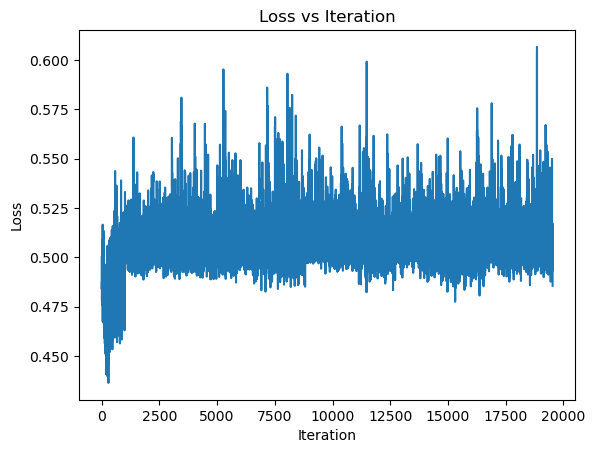

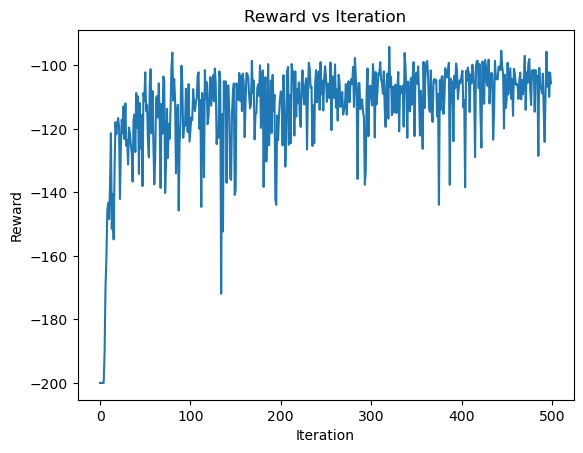

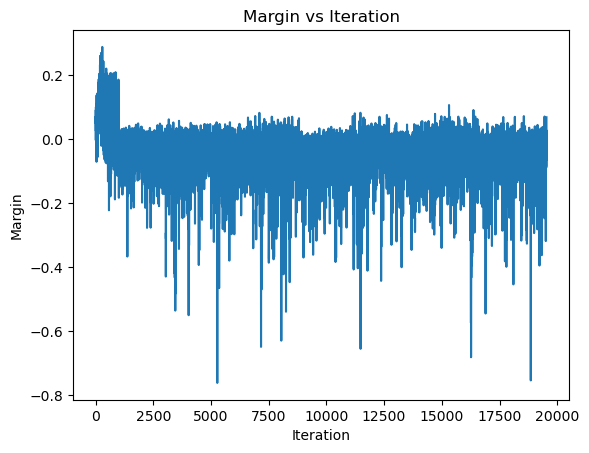

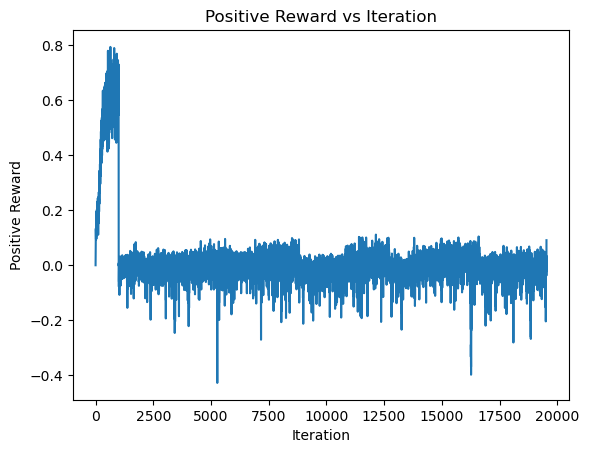

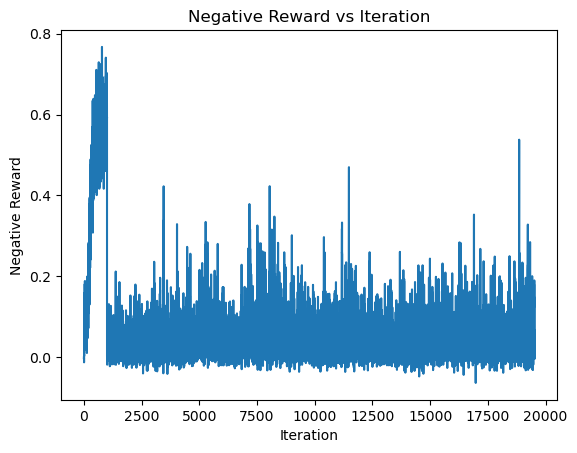

In [18]:
# save all png to /mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./Simple_loss.png")
plt.show()




# draw the reward graph

plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.savefig("./Simple_reward.png")
plt.show()

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.savefig("./Simple_margin.png")
plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.savefig("./Simple_positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")
plt.savefig("./Simple_negative_reward.png")
plt.show()


# Complex KTO

In [15]:
policy_network = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)

nn.init.kaiming_normal_(policy_network.fc1.weight)
nn.init.kaiming_normal_(policy_network.fc2.weight)
nn.init.kaiming_normal_(policy_network.fc3.weight)
prev = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-4)
env=make_vec_env_sb3(env_id, n_envs=1)

# Training loop
num_epochs = 5
batch_size = 128

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//100
now_log=0
now_pos=0
prev_load_freq = 1000
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        model_dist = Categorical(logits=logits)
        model_act_sample = model_dist.sample()
        policy_chosen_logps = model_dist.log_prob(act_batch)
        policy_rejected_logps = model_dist.log_prob(model_act_sample)
        with torch.no_grad():
            prev_logits = prev(obs_batch)
            prev_dist = Categorical(logits=prev_logits)
            reference_chosen_logps = prev_dist.log_prob(act_batch)
            reference_rejected_logps = prev_dist.log_prob(model_act_sample)
        
        
        beta = 1
        desirable_weight = 1
        undesirable_weight = 1

        # complex version KTO

        KL = kl_divergence(model_dist, prev_dist).mean()
        chosen_logratios = (policy_chosen_logps - reference_chosen_logps)
        chosen_losses = 1 - F.sigmoid(beta * (chosen_logratios - KL))
        chosen_rewards = beta * chosen_logratios.detach()
        rejected_logratios = (policy_rejected_logps - reference_rejected_logps)
        rejected_losses = 1 - F.sigmoid(beta * (KL - rejected_logratios))
        rejected_rewards = beta * rejected_logratios.detach()

        losses = torch.cat((desirable_weight * chosen_losses, undesirable_weight * rejected_losses), 0)

        loss=losses.mean()

 
        # Optimize the policy
        
        optimizer.zero_grad()

        if (step+1) % prev_load_freq == 0:
            
            prev.load_state_dict(policy_network.state_dict())
            prev.eval()

        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_rewards.mean().item()
        negative_reward = rejected_rewards.mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        total_reward=0
        num_test=10
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"epoch_{epoch+1}_iteration_{now_pos}.gif"
                    imageio.mimsave("./KTO_gif/"+image_path, frames)

            print(total_reward/num_test)
            eval_rewards.append(total_reward/num_test)
            policy_network.train()  # 切换回训练模式


         

env.close()

Epoch [1/5]:   0%|          | 14/3907 [00:00<00:28, 138.11it/s, loss=0.49, positive_reward=0.372, negative_reward=0.279, margin=0.0931] 

Epoch [1/5]:   1%|          | 39/3907 [00:01<02:22, 27.24it/s, loss=0.492, positive_reward=0.423, negative_reward=0.347, margin=0.076]  


KeyboardInterrupt: 

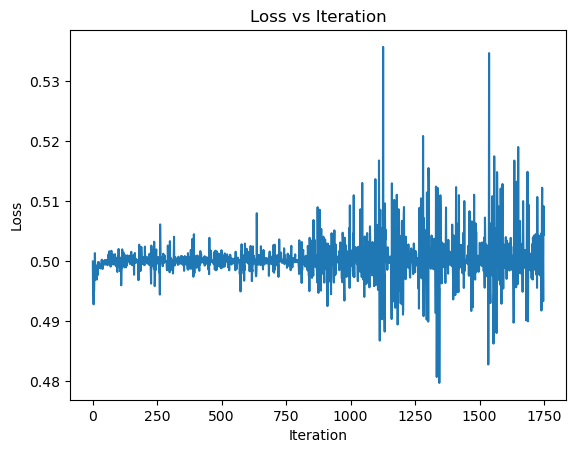

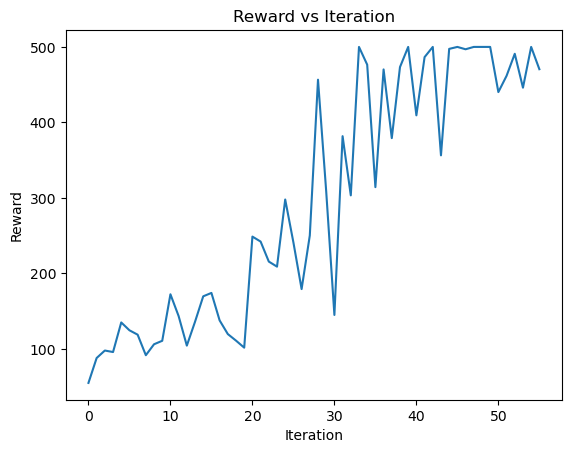

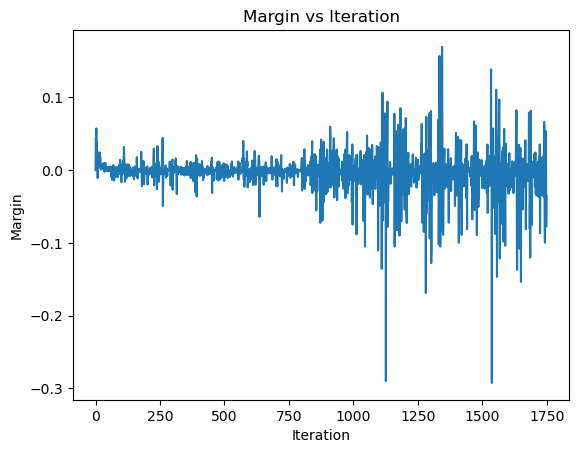

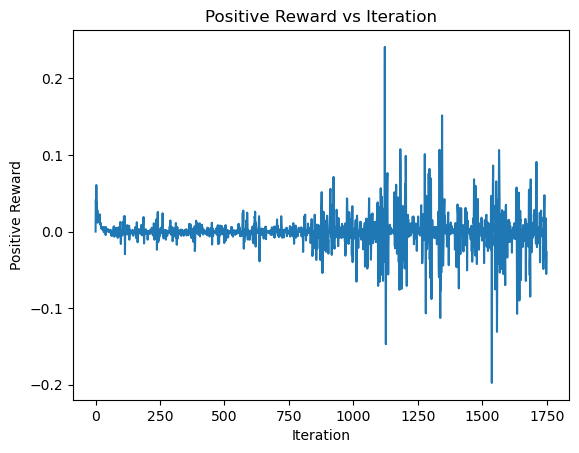

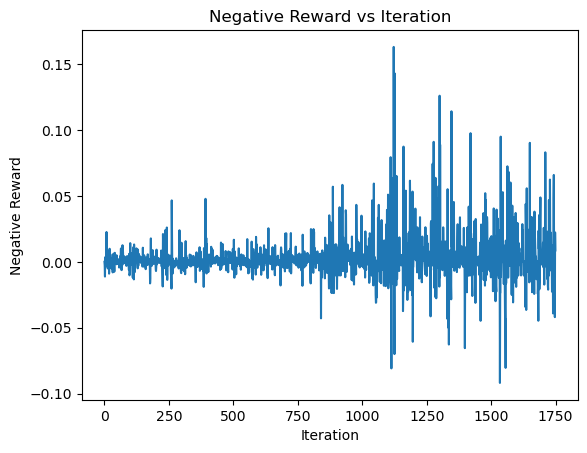

<Figure size 640x480 with 0 Axes>

In [ ]:
# save all png to /mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./loss.png")
plt.show()




# draw the reward graph

plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.savefig("./reward.png")
plt.show()

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.savefig("./margin.png")
plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.savefig("./positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")
plt.savefig("./negative_reward.png")
plt.show()
